In [1]:
import tifffile
import numpy as np
from pathlib import Path
import json

def print_qptiff_details(filepath):
    """
    Print comprehensive details of a QPTIFF (QuPath-compatible TIFF) file.
    
    Args:
        filepath (str): Path to the QPTIFF file
    """
    
    try:
        # Check if file exists
        if not Path(filepath).exists():
            print(f"Error: File '{filepath}' not found.")
            return
        
        print(f"=== QPTIFF File Details: {Path(filepath).name} ===\n")
        
        # Open the TIFF file
        with tifffile.TiffFile(filepath) as tif:
            
            # Basic file information
            print("📁 FILE INFORMATION:")
            print(f"   File size: {Path(filepath).stat().st_size / (1024*1024):.2f} MB")
            print(f"   Number of pages: {len(tif.pages)}")
            print(f"   Is pyramidal: {'Yes' if len(tif.series[0].levels) > 1 else 'No'}")
            print()
            
            # Main image properties
            main_page = tif.pages[0]
            print("🖼️  MAIN IMAGE PROPERTIES:")
            print(f"   Dimensions: {main_page.shape}")
            print(f"   Data type: {main_page.dtype}")
            print(f"   Bits per sample: {main_page.bitspersample}")
            print(f"   Samples per pixel: {main_page.samplesperpixel}")
            print(f"   Photometric: {main_page.photometric}")
            print(f"   Compression: {main_page.compression}")
            print(f"   Planar config: {main_page.planarconfig}")
            print()
            
            # Pyramid levels (if available)
            if len(tif.series[0].levels) > 1:
                print("📊 PYRAMID LEVELS:")
                for i, level in enumerate(tif.series[0].levels):
                    page = level.pages[0]
                    print(f"   Level {i}: {page.shape} - {page.dtype}")
                print()
            
            # TIFF tags
            print("🏷️  TIFF TAGS:")
            tags = main_page.tags
            important_tags = [
                'ImageWidth', 'ImageLength', 'XResolution', 'YResolution',
                'ResolutionUnit', 'Software', 'DateTime', 'Artist',
                'ImageDescription', 'Make', 'Model'
            ]
            
            for tag_name in important_tags:
                if hasattr(tags, tag_name.lower()):
                    tag = getattr(tags, tag_name.lower())
                    if tag.value:
                        print(f"   {tag_name}: {tag.value}")
            
            # Check for custom tags that might be QuPath-specific
            print("\n🔍 CUSTOM/UNKNOWN TAGS:")
            for tag in tags:
                if tag.name.startswith('Tag') or tag.code > 50000:
                    try:
                        value_str = str(tag.value)
                        if len(value_str) > 100:
                            value_str = value_str[:100] + "..."
                        print(f"   Tag {tag.code}: {value_str}")
                    except:
                        print(f"   Tag {tag.code}: <unable to decode>")
            
            print()
            
            # Try to extract QuPath-specific metadata
            print("🔬 QUPATH METADATA:")
            
            # Check ImageDescription for QuPath data
            if hasattr(tags, 'imagedescription') and tags.imagedescription.value:
                desc = tags.imagedescription.value
                if isinstance(desc, bytes):
                    desc = desc.decode('utf-8', errors='ignore')
                
                # Try to parse as JSON (QuPath sometimes stores metadata as JSON)
                try:
                    if desc.strip().startswith('{'):
                        metadata = json.loads(desc)
                        print("   Parsed JSON metadata:")
                        for key, value in metadata.items():
                            print(f"      {key}: {value}")
                    else:
                        print(f"   Description: {desc[:200]}{'...' if len(desc) > 200 else ''}")
                except json.JSONDecodeError:
                    print(f"   Description: {desc[:200]}{'...' if len(desc) > 200 else ''}")
            
            # Check for OME-XML metadata (sometimes used with QuPath)
            if hasattr(tags, 'software') and tags.software.value:
                software = tags.software.value
                if isinstance(software, bytes):
                    software = software.decode('utf-8', errors='ignore')
                print(f"   Software: {software}")
            
            # Pixel size information
            print("\n📐 PIXEL SIZE INFORMATION:")
            if hasattr(tags, 'xresolution') and hasattr(tags, 'yresolution'):
                x_res = tags.xresolution.value
                y_res = tags.yresolution.value
                unit = getattr(tags, 'resolutionunit', None)
                
                if isinstance(x_res, tuple) and len(x_res) == 2:
                    x_res = x_res[0] / x_res[1]
                if isinstance(y_res, tuple) and len(y_res) == 2:
                    y_res = y_res[0] / y_res[1]
                
                unit_str = "pixels/inch" if unit and unit.value == 2 else "unknown unit"
                
                print(f"   X Resolution: {x_res} {unit_str}")
                print(f"   Y Resolution: {y_res} {unit_str}")
                
                if unit and unit.value == 2:  # inches
                    # Convert to micrometers per pixel
                    x_microns = 25400 / x_res  # 25400 micrometers per inch
                    y_microns = 25400 / y_res
                    print(f"   Pixel size: {x_microns:.3f} x {y_microns:.3f} μm/pixel")
            
            print("\n" + "="*50)
            
    except tifffile.TiffFileError as e:
        print(f"Error reading TIFF file: {e}")
    except Exception as e:
        print(f"Unexpected error: {e}")

# Example usage
if __name__ == "__main__":
    # Replace with your QPTIFF file path
    file_path = "valis_input/Pair 1 - SU9-7833 H/CD8 unmixed IF test.qptiff"  # or .tif
    
    # You can also use input to get the file path interactively
    # file_path = input("Enter the path to your QPTIFF file: ")
    
    print_qptiff_details(file_path)
    
    # Alternative: Process multiple files
    """
    import glob
    
    # Process all QPTIFF files in a directory
    qptiff_files = glob.glob("*.qptiff") + glob.glob("*.tif")
    
    for file_path in qptiff_files:
        print_qptiff_details(file_path)
        print("\n" + "="*80 + "\n")
    """

=== QPTIFF File Details: CD8 unmixed IF test.qptiff ===

📁 FILE INFORMATION:
   File size: 10548.93 MB
   Number of pages: 51
   Is pyramidal: Yes

🖼️  MAIN IMAGE PROPERTIES:
   Dimensions: (54720, 26880)
   Data type: uint16
   Bits per sample: 16
   Samples per pixel: 1
   Photometric: 1
   Compression: 5
   Planar config: 1

📊 PYRAMID LEVELS:
   Level 0: (54720, 26880) - uint16
   Level 1: (27360, 13440) - uint16
   Level 2: (13680, 6720) - uint16
   Level 3: (6840, 3360) - uint16
   Level 4: (3420, 1680) - uint16
   Level 5: (1710, 840) - uint16

🏷️  TIFF TAGS:

🔍 CUSTOM/UNKNOWN TAGS:

🔬 QUPATH METADATA:

📐 PIXEL SIZE INFORMATION:



In [31]:
import tifffile
import numpy as np
from pathlib import Path
import os

def extract_channels_to_tiff(input_path, output_path, channels_to_extract, total_channels=8):
    """
    Extract specific channels from a QPTIFF file and save as a regular multi-channel TIFF.
    Only extracts the highest resolution (level 0).
    
    Args:
        input_path (str): Path to input QPTIFF file
        output_path (str): Path to output TIFF file
        channels_to_extract (list): List of channel indices to extract (0-based)
        total_channels (int): Total number of channels in the original file
    """
    
    print(f"Extracting channels {channels_to_extract} from {Path(input_path).name}")
    print(f"Output file: {Path(output_path).name}")
    
    try:
        with tifffile.TiffFile(input_path) as tif:
            total_pages = len(tif.pages)
            num_levels = len(tif.series[0].levels)
            
            print(f"Total pages: {total_pages}")
            print(f"Pyramid levels: {num_levels}")
            print(f"Extracting only level 0 (highest resolution)")
            
            # Extract channels from level 0 only
            level = 0
            extracted_data = []
            
            print(f"Processing level {level}...")
            
            for channel in channels_to_extract:
                # Calculate the page index for level 0 and this channel
                page_idx = level * total_channels + channel
                
                if page_idx < total_pages:
                    page = tif.pages[page_idx]
                    data = page.asarray()
                    extracted_data.append(data)
                    print(f"  Extracted channel {channel}, shape: {data.shape}")
                else:
                    print(f"  Error: Page {page_idx} not found for channel {channel}")
                    return
            
            # Stack the channels into a single array
            if len(extracted_data) > 1:
                # Stack along a new first axis to create (channels, height, width)
                multi_channel_data = np.stack(extracted_data, axis=0)
                print(f"Final data shape: {multi_channel_data.shape} (channels, height, width)")
            else:
                # Single channel case
                multi_channel_data = extracted_data[0]
                print(f"Final data shape: {multi_channel_data.shape} (single channel)")
            
            # Get metadata from the first page
            first_page = tif.pages[0]
            tags = first_page.tags
            
            # Prepare metadata for the new TIFF
            metadata = {}
            
            # Try to preserve resolution information
            if hasattr(tags, 'xresolution') and tags.xresolution.value:
                metadata['resolution'] = (tags.xresolution.value, tags.yresolution.value)
                if hasattr(tags, 'resolutionunit') and tags.resolutionunit.value:
                    metadata['resolutionunit'] = tags.resolutionunit.value
            
            # Preserve software information
            if hasattr(tags, 'software') and tags.software.value:
                metadata['software'] = tags.software.value
            
            # Add custom description
            original_desc = ""
            if hasattr(tags, 'imagedescription') and tags.imagedescription.value:
                original_desc = tags.imagedescription.value
                if isinstance(original_desc, bytes):
                    original_desc = original_desc.decode('utf-8', errors='ignore')
            
            new_desc = f"Multi-channel TIFF. Extracted channels: {channels_to_extract} from QuPath TIFF. Original: {original_desc}"
            metadata['description'] = new_desc
            
            # Create output directory if it doesn't exist
            output_path_obj = Path(output_path)
            output_path_obj.parent.mkdir(parents=True, exist_ok=True)
            print(f"Output directory created: {output_path_obj.parent}")
            
            # Write the multi-channel TIFF
            print(f"Writing multi-channel TIFF to {output_path}...")
            
            tifffile.imwrite(
                output_path,
                multi_channel_data,
                compression='lzw',
                photometric='minisblack',
                planarconfig='contig',
                **metadata
            )
            
            print(f"✅ Successfully created {output_path}")
            
            # Print summary
            new_size = os.path.getsize(output_path) / (1024*1024)
            original_size = os.path.getsize(input_path) / (1024*1024)
            print(f"Original file size: {original_size:.2f} MB")
            print(f"New file size: {new_size:.2f} MB")
            print(f"Size reduction: {((original_size - new_size) / original_size) * 100:.1f}%")
            
    except Exception as e:
        print(f"Error: {e}")
        import traceback
        traceback.print_exc()

def verify_tiff_file(filepath, expected_channels):
    """
    Verify that the extracted TIFF file has the correct structure.
    """
    print(f"\n=== Verifying {Path(filepath).name} ===")
    
    with tifffile.TiffFile(filepath) as tif:
        data = tif.asarray()
        
        print(f"Data shape: {data.shape}")
        print(f"Data type: {data.dtype}")
        
        if len(data.shape) == 3:
            print(f"Number of channels: {data.shape[0]}")
            print(f"Image dimensions: {data.shape[1]} x {data.shape[2]}")
            print(f"Expected channels: {len(expected_channels)}")
            
            # Check some basic statistics for each channel
            for i in range(data.shape[0]):
                channel_data = data[i]
                print(f"Channel {i}: min={channel_data.min()}, max={channel_data.max()}, mean={channel_data.mean():.2f}")
        else:
            print(f"Single channel image: {data.shape}")

# Main execution
if __name__ == "__main__":
    # Configuration
    input_file = "valis_input/Pair 25/SU18-50119 1H_New unmixed IF.qptiff"
    output_file = "RegWSI_Pass1/Pair25/target.tiff"
    channels_to_extract = [0, 1, 5]  # Channels you want to keep
    total_channels = 8  # Total channels in original file
    
    # Extract channels
    extract_channels_to_tiff(
        input_path=input_file,
        output_path=output_file,
        channels_to_extract=channels_to_extract,
        total_channels=total_channels
    )
    
    # Verify the result
    if Path(output_file).exists():
        verify_tiff_file(output_file, channels_to_extract)
        print(f"✅ Successfully created: {output_file}")
    
    print("\n🎉 Channel extraction complete!")

Extracting channels [0, 1, 5] from SU18-50119 1H_New unmixed IF.qptiff
Output file: target.tiff
Total pages: 51
Pyramid levels: 6
Extracting only level 0 (highest resolution)
Processing level 0...
  Extracted channel 0, shape: (34560, 32640)


  Extracted channel 1, shape: (34560, 32640)
  Extracted channel 5, shape: (34560, 32640)
Final data shape: (3, 34560, 32640) (channels, height, width)
Output directory created: RegWSI_Pass1/Pair25
Writing multi-channel TIFF to RegWSI_Pass1/Pair25/target.tiff...
✅ Successfully created RegWSI_Pass1/Pair25/target.tiff
Original file size: 5375.91 MB
New file size: 1612.29 MB
Size reduction: 70.0%

=== Verifying target.tiff ===
Data shape: (3, 34560, 32640)
Data type: uint16
Number of channels: 3
Image dimensions: 34560 x 32640
Expected channels: 3
Channel 0: min=0, max=4171, mean=41.48
Channel 1: min=0, max=5049, mean=19.53
Channel 2: min=0, max=2754, mean=2.47
✅ Successfully created: RegWSI_Pass1/Pair25/target.tiff

🎉 Channel extraction complete!


In [28]:
import tifffile
import numpy as np
from pathlib import Path
import os

def extract_channels_to_tiff(input_path, output_path, channels_to_extract, total_channels=8):
    """
    Extract specific channels from a QPTIFF file and save as a regular multi-channel TIFF.
    Only extracts the highest resolution (level 0).
    
    Args:
        input_path (str): Path to input QPTIFF file
        output_path (str): Path to output TIFF file
        channels_to_extract (list): List of channel indices to extract (0-based)
        total_channels (int): Total number of channels in the original file
    """
    
    print(f"Extracting channels {channels_to_extract} from {Path(input_path).name}")
    print(f"Output file: {Path(output_path).name}")
    
    try:
        with tifffile.TiffFile(input_path) as tif:
            total_pages = len(tif.pages)
            num_levels = len(tif.series[0].levels)
            
            print(f"Total pages: {total_pages}")
            print(f"Pyramid levels: {num_levels}")
            print(f"Extracting only level 0 (highest resolution)")
            
            # Extract channels from level 0 only
            level = 0
            extracted_data = []
            
            print(f"Processing level {level}...")
            
            for channel in channels_to_extract:
                # Calculate the page index for level 0 and this channel
                page_idx = level * total_channels + channel
                
                if page_idx < total_pages:
                    page = tif.pages[page_idx]
                    data = page.asarray()
                    extracted_data.append(data)
                    print(f"  Extracted channel {channel}, shape: {data.shape}")
                else:
                    print(f"  Error: Page {page_idx} not found for channel {channel}")
                    return
            
            # Stack the channels into a single array
            if len(extracted_data) > 1:
                # Stack along a new first axis to create (channels, height, width)
                multi_channel_data = np.stack(extracted_data, axis=0)
                print(f"Final data shape: {multi_channel_data.shape} (channels, height, width)")
            else:
                # Single channel case
                multi_channel_data = extracted_data[0]
                print(f"Final data shape: {multi_channel_data.shape} (single channel)")
            
            # Get metadata from the first page
            first_page = tif.pages[0]
            tags = first_page.tags
            
            # Prepare metadata for the new TIFF
            metadata = {}
            
            # Try to preserve resolution information
            if hasattr(tags, 'xresolution') and tags.xresolution.value:
                metadata['resolution'] = (tags.xresolution.value, tags.yresolution.value)
                if hasattr(tags, 'resolutionunit') and tags.resolutionunit.value:
                    metadata['resolutionunit'] = tags.resolutionunit.value
            
            # Preserve software information
            if hasattr(tags, 'software') and tags.software.value:
                metadata['software'] = tags.software.value
            
            # Add custom description
            original_desc = ""
            if hasattr(tags, 'imagedescription') and tags.imagedescription.value:
                original_desc = tags.imagedescription.value
                if isinstance(original_desc, bytes):
                    original_desc = original_desc.decode('utf-8', errors='ignore')
            
            new_desc = f"Multi-channel TIFF. Extracted channels: {channels_to_extract} from QuPath TIFF. Original: {original_desc}"
            metadata['description'] = new_desc
            
            # Create output directory if it doesn't exist
            output_path_obj = Path(output_path)
            output_path_obj.parent.mkdir(parents=True, exist_ok=True)
            print(f"Output directory created: {output_path_obj.parent}")
            
            # Write the multi-channel TIFF
            print(f"Writing multi-channel TIFF to {output_path}...")
            
            # Calculate expected file size
            expected_size_gb = (multi_channel_data.size * multi_channel_data.itemsize) / (1024**3)
            print(f"Expected file size: {expected_size_gb:.2f} GB")
            
            # Use BigTIFF if file size > 4GB
            use_bigtiff = expected_size_gb > 4.0
            if use_bigtiff:
                print("Using BigTIFF format for large file...")
            
            tifffile.imwrite(
                output_path,
                multi_channel_data,
                bigtiff=use_bigtiff,
                compression='lzw',
                photometric='minisblack',
                planarconfig='contig',
                tile=(512, 512),  # Use tiled format for better performance with large files
                **metadata
            )
            
            print(f"✅ Successfully created {output_path}")
            
            # Print summary
            new_size = os.path.getsize(output_path) / (1024*1024)
            original_size = os.path.getsize(input_path) / (1024*1024)
            print(f"Original file size: {original_size:.2f} MB")
            print(f"New file size: {new_size:.2f} MB")
            print(f"Size reduction: {((original_size - new_size) / original_size) * 100:.1f}%")
            
    except Exception as e:
        print(f"Error: {e}")
        import traceback
        traceback.print_exc()

def verify_tiff_file(filepath, expected_channels):
    """
    Verify that the extracted TIFF file has the correct structure.
    """
    print(f"\n=== Verifying {Path(filepath).name} ===")
    
    with tifffile.TiffFile(filepath) as tif:
        data = tif.asarray()
        
        print(f"Data shape: {data.shape}")
        print(f"Data type: {data.dtype}")
        
        if len(data.shape) == 3:
            print(f"Number of channels: {data.shape[0]}")
            print(f"Image dimensions: {data.shape[1]} x {data.shape[2]}")
            print(f"Expected channels: {len(expected_channels)}")
            
            # Check some basic statistics for each channel
            for i in range(data.shape[0]):
                channel_data = data[i]
                print(f"Channel {i}: min={channel_data.min()}, max={channel_data.max()}, mean={channel_data.mean():.2f}")
        else:
            print(f"Single channel image: {data.shape}")

# Main execution
if __name__ == "__main__":
    # Configuration
    input_file = "valis_input/Pair 21/BS15-E45224 C18_New unmixed IF.qptiff"
    output_file = "RegWSI_Pass1/Pair21/target.tiff"
    channels_to_extract = [0, 1, 5]  # Channels you want to keep
    total_channels = 8  # Total channels in original file
    
    # Extract channels
    extract_channels_to_tiff(
        input_path=input_file,
        output_path=output_file,
        channels_to_extract=channels_to_extract,
        total_channels=total_channels
    )
    
    # Verify the result
    if Path(output_file).exists():
        verify_tiff_file(output_file, channels_to_extract)
        print(f"✅ Successfully created: {output_file}")
    
    print("\n🎉 Channel extraction complete!")

Extracting channels [0, 1, 5] from BS15-E45224 C18_New unmixed IF.qptiff
Output file: target.tiff
Total pages: 59
Pyramid levels: 7
Extracting only level 0 (highest resolution)
Processing level 0...


  Extracted channel 0, shape: (69120, 42240)
  Extracted channel 1, shape: (69120, 42240)
  Extracted channel 5, shape: (69120, 42240)
Final data shape: (3, 69120, 42240) (channels, height, width)
Output directory created: RegWSI_Pass1/Pair21
Writing multi-channel TIFF to RegWSI_Pass1/Pair21/target.tiff...
Expected file size: 16.31 GB
Using BigTIFF format for large file...
✅ Successfully created RegWSI_Pass1/Pair21/target.tiff
Original file size: 9876.73 MB
New file size: 4979.68 MB
Size reduction: 49.6%

=== Verifying target.tiff ===
Data shape: (3, 69120, 42240)
Data type: uint16
Number of channels: 3
Image dimensions: 69120 x 42240
Expected channels: 3
Channel 0: min=0, max=4908, mean=28.42
Channel 1: min=0, max=4645, mean=7.48
Channel 2: min=0, max=4148, mean=3.15
✅ Successfully created: RegWSI_Pass1/Pair21/target.tiff

🎉 Channel extraction complete!


Loading TIFF file: target.tiff
Image shape: (3, 54720, 26880)
Data type: uint16
Number of channels: 3
Processing Channel 0...
  Original size: (54720, 26880)
  Value range: 0 - 4706
  Thumbnail size: (1024, 503)
  Enhanced range: 0.0 - 65535.0
Processing Channel 1...
  Original size: (54720, 26880)
  Value range: 0 - 4158
  Thumbnail size: (1024, 503)
  Enhanced range: 0.0 - 65535.0
Processing Channel 2...
  Original size: (54720, 26880)
  Value range: 0 - 4948
  Thumbnail size: (1024, 503)
  Enhanced range: 0.0 - 65535.0
Plots saved to: RegWSI_Pass1/Pair1/target_visualization


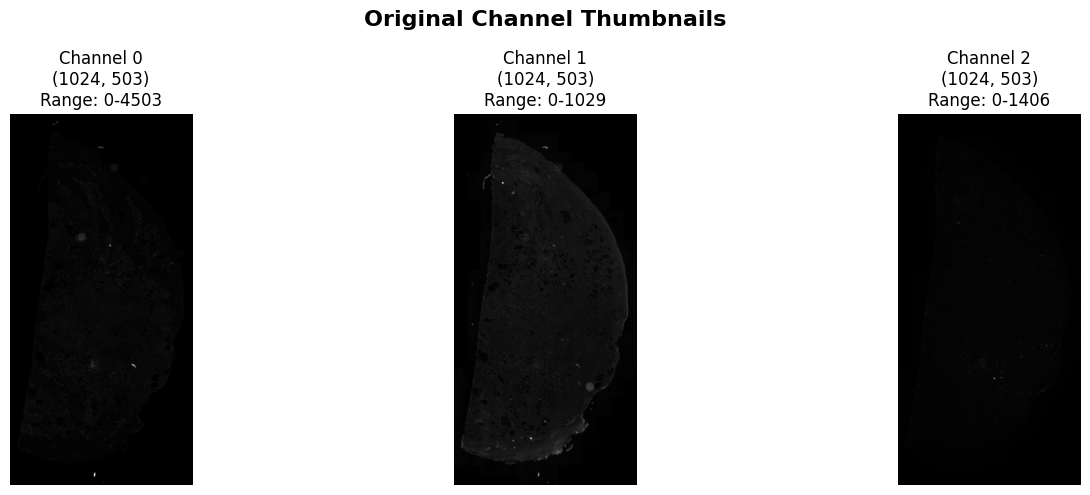

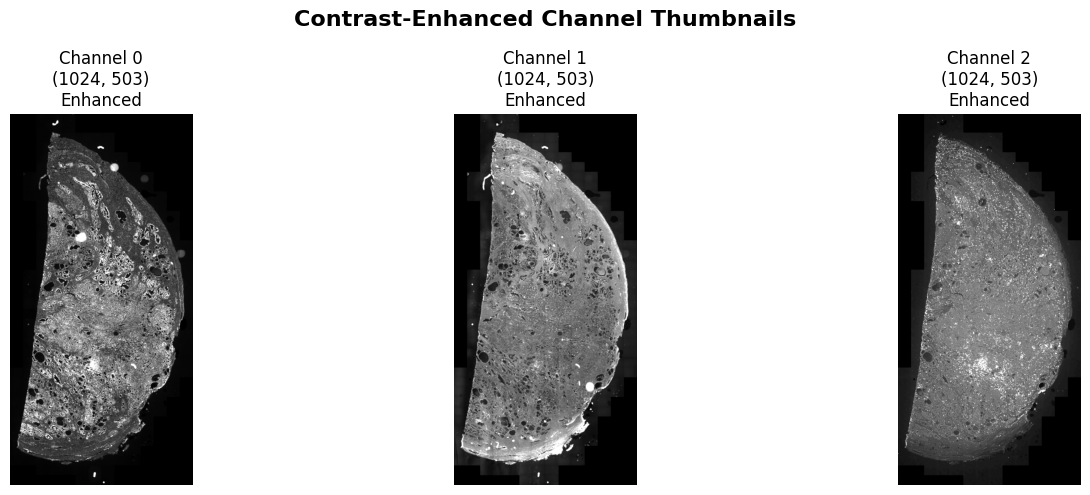

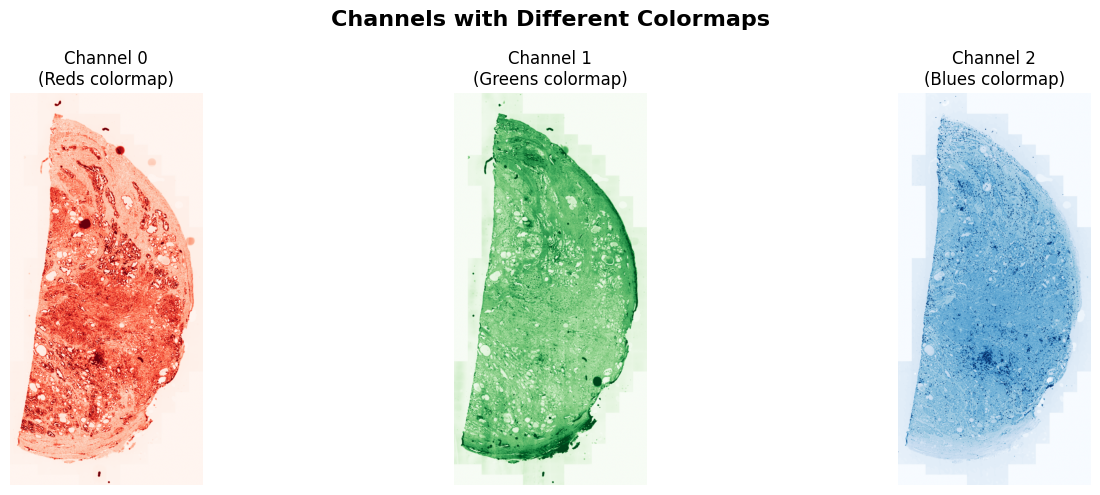

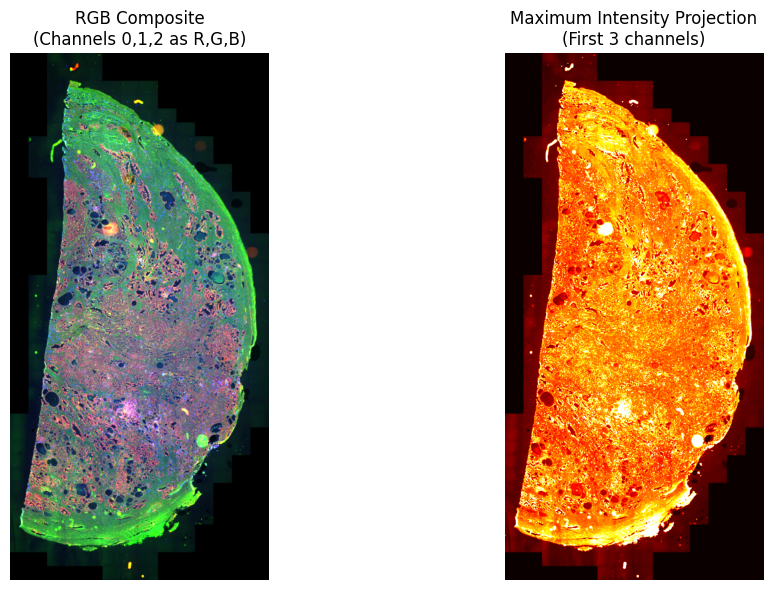

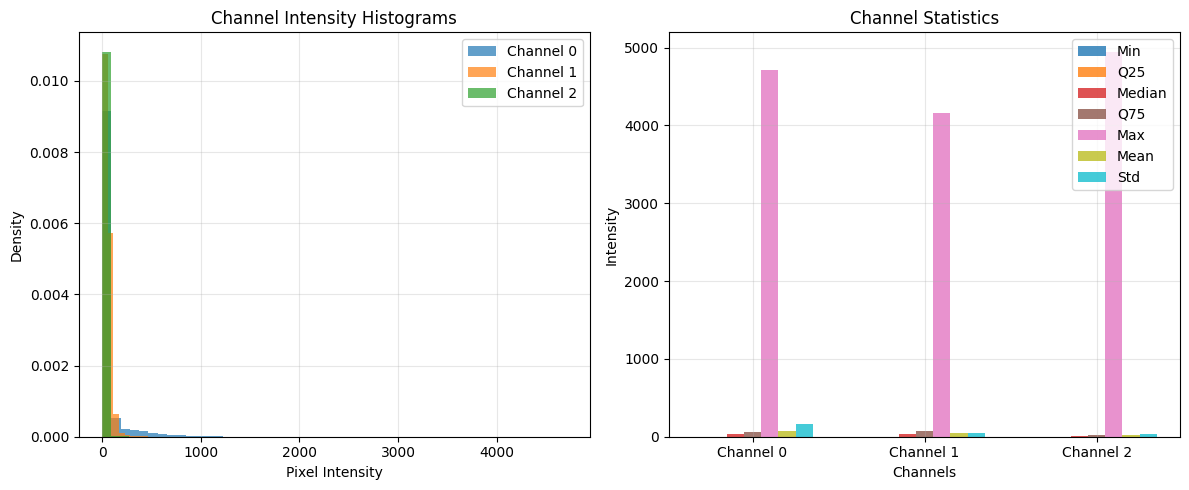

In [4]:
import tifffile
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from skimage import exposure
from skimage.transform import resize
import warnings
warnings.filterwarnings('ignore')

def create_thumbnail(image, max_size=2048):
    """
    Create a thumbnail of the image while maintaining aspect ratio.
    
    Args:
        image (np.array): Input image
        max_size (int): Maximum size for the largest dimension
    
    Returns:
        np.array: Thumbnailed image
    """
    height, width = image.shape
    
    # Calculate scaling factor
    scale = min(max_size / height, max_size / width)
    
    if scale < 1:
        new_height = int(height * scale)
        new_width = int(width * scale)
        thumbnail = resize(image, (new_height, new_width), preserve_range=True, anti_aliasing=True)
        return thumbnail.astype(image.dtype)
    else:
        return image

def enhance_contrast(image, percentile_range=(1, 99)):
    """
    Enhance image contrast using percentile-based stretching.
    
    Args:
        image (np.array): Input image
        percentile_range (tuple): Lower and upper percentiles for contrast stretching
    
    Returns:
        np.array: Contrast-enhanced image
    """
    p_low, p_high = np.percentile(image, percentile_range)
    if p_high > p_low:
        return exposure.rescale_intensity(image, in_range=(p_low, p_high))
    else:
        return image

def visualize_tiff_channels(filepath, thumbnail_size=1024, save_plots=False):
    """
    Visualize each channel of a multi-channel TIFF file.
    
    Args:
        filepath (str): Path to the TIFF file
        thumbnail_size (int): Maximum size for thumbnails
        save_plots (bool): Whether to save the plots as PNG files
    """
    
    print(f"Loading TIFF file: {Path(filepath).name}")
    
    try:
        # Load the TIFF file
        with tifffile.TiffFile(filepath) as tif:
            data = tif.asarray()
        
        print(f"Image shape: {data.shape}")
        print(f"Data type: {data.dtype}")
        
        # Handle different image formats
        if len(data.shape) == 2:
            # Single channel image
            channels = [data]
            channel_names = ['Channel 0']
        elif len(data.shape) == 3:
            # Multi-channel image - assume (channels, height, width)
            if data.shape[0] < data.shape[1] and data.shape[0] < data.shape[2]:
                # Format: (channels, height, width)
                channels = [data[i] for i in range(data.shape[0])]
                channel_names = [f'Channel {i}' for i in range(data.shape[0])]
            else:
                # Format: (height, width, channels)
                channels = [data[:, :, i] for i in range(data.shape[2])]
                channel_names = [f'Channel {i}' for i in range(data.shape[2])]
        else:
            print("Unsupported image format")
            return
        
        num_channels = len(channels)
        print(f"Number of channels: {num_channels}")
        
        # Create thumbnails and enhance contrast
        thumbnails = []
        enhanced_thumbnails = []
        
        for i, channel in enumerate(channels):
            print(f"Processing {channel_names[i]}...")
            print(f"  Original size: {channel.shape}")
            print(f"  Value range: {channel.min()} - {channel.max()}")
            
            # Create thumbnail
            thumb = create_thumbnail(channel, thumbnail_size)
            thumbnails.append(thumb)
            
            # Enhance contrast
            enhanced_thumb = enhance_contrast(thumb)
            enhanced_thumbnails.append(enhanced_thumb)
            
            print(f"  Thumbnail size: {thumb.shape}")
            print(f"  Enhanced range: {enhanced_thumb.min():.1f} - {enhanced_thumb.max():.1f}")
        
        # Visualization
        # Plot 1: Original thumbnails
        fig1, axes1 = plt.subplots(1, num_channels, figsize=(5*num_channels, 5))
        if num_channels == 1:
            axes1 = [axes1]
        
        fig1.suptitle('Original Channel Thumbnails', fontsize=16, fontweight='bold')
        
        for i, (thumb, name) in enumerate(zip(thumbnails, channel_names)):
            axes1[i].imshow(thumb, cmap='gray', vmin=thumb.min(), vmax=thumb.max())
            axes1[i].set_title(f'{name}\n{thumb.shape}\nRange: {thumb.min():.0f}-{thumb.max():.0f}')
            axes1[i].axis('off')
        
        plt.tight_layout()
        
        # Plot 2: Contrast-enhanced thumbnails
        fig2, axes2 = plt.subplots(1, num_channels, figsize=(5*num_channels, 5))
        if num_channels == 1:
            axes2 = [axes2]
        
        fig2.suptitle('Contrast-Enhanced Channel Thumbnails', fontsize=16, fontweight='bold')
        
        for i, (enhanced_thumb, name) in enumerate(zip(enhanced_thumbnails, channel_names)):
            axes2[i].imshow(enhanced_thumb, cmap='gray')
            axes2[i].set_title(f'{name}\n{enhanced_thumb.shape}\nEnhanced')
            axes2[i].axis('off')
        
        plt.tight_layout()
        
        # Plot 3: Channels with different colormaps
        if num_channels > 1:
            fig3, axes3 = plt.subplots(1, num_channels, figsize=(5*num_channels, 5))
            if num_channels == 1:
                axes3 = [axes3]
            
            fig3.suptitle('Channels with Different Colormaps', fontsize=16, fontweight='bold')
            
            # Different colormaps for each channel
            colormaps = ['Reds', 'Greens', 'Blues', 'Purples', 'Oranges', 'viridis', 'plasma', 'inferno']
            
            for i, (enhanced_thumb, name) in enumerate(zip(enhanced_thumbnails, channel_names)):
                cmap = colormaps[i % len(colormaps)]
                axes3[i].imshow(enhanced_thumb, cmap=cmap)
                axes3[i].set_title(f'{name}\n({cmap} colormap)')
                axes3[i].axis('off')
            
            plt.tight_layout()
        
        # Plot 4: Composite view (if multiple channels)
        if num_channels >= 3:
            fig4, axes4 = plt.subplots(1, 2, figsize=(12, 6))
            
            # RGB composite (using first 3 channels)
            rgb_composite = np.zeros((*enhanced_thumbnails[0].shape, 3))
            for i in range(min(3, num_channels)):
                # Normalize each channel to 0-1
                channel_norm = (enhanced_thumbnails[i] - enhanced_thumbnails[i].min()) / \
                              (enhanced_thumbnails[i].max() - enhanced_thumbnails[i].min())
                rgb_composite[:, :, i] = channel_norm
            
            axes4[0].imshow(rgb_composite)
            axes4[0].set_title('RGB Composite\n(Channels 0,1,2 as R,G,B)')
            axes4[0].axis('off')
            
            # Overlay composite
            overlay = np.maximum.reduce(enhanced_thumbnails[:3])
            axes4[1].imshow(overlay, cmap='hot')
            axes4[1].set_title('Maximum Intensity Projection\n(First 3 channels)')
            axes4[1].axis('off')
            
            plt.tight_layout()
        
        # Plot 5: Channel statistics
        fig5, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
        
        # Histogram for each channel
        for i, (channel, name) in enumerate(zip(channels, channel_names)):
            # Sample data for histogram (use every 100th pixel to speed up)
            sample_data = channel.flatten()[::100]
            ax1.hist(sample_data, bins=50, alpha=0.7, label=name, density=True)
        
        ax1.set_xlabel('Pixel Intensity')
        ax1.set_ylabel('Density')
        ax1.set_title('Channel Intensity Histograms')
        ax1.legend()
        ax1.grid(True, alpha=0.3)
        
        # Channel statistics bar plot
        stats = []
        for channel in channels:
            stats.append([
                channel.min(),
                np.percentile(channel, 25),
                np.median(channel),
                np.percentile(channel, 75),
                channel.max(),
                channel.mean(),
                channel.std()
            ])
        
        stats = np.array(stats)
        x = np.arange(len(channel_names))
        width = 0.1
        
        stat_names = ['Min', 'Q25', 'Median', 'Q75', 'Max', 'Mean', 'Std']
        colors = plt.cm.tab10(np.linspace(0, 1, len(stat_names)))
        
        for i, (stat_name, color) in enumerate(zip(stat_names, colors)):
            ax2.bar(x + i*width, stats[:, i], width, label=stat_name, color=color, alpha=0.8)
        
        ax2.set_xlabel('Channels')
        ax2.set_ylabel('Intensity')
        ax2.set_title('Channel Statistics')
        ax2.set_xticks(x + width*3)
        ax2.set_xticklabels(channel_names)
        ax2.legend()
        ax2.grid(True, alpha=0.3)
        
        plt.tight_layout()
        
        # Save plots if requested
        if save_plots:
            output_dir = Path(filepath).parent / f"{Path(filepath).stem}_visualization"
            output_dir.mkdir(exist_ok=True)
            
            fig1.savefig(output_dir / "01_original_thumbnails.png", dpi=300, bbox_inches='tight')
            fig2.savefig(output_dir / "02_enhanced_thumbnails.png", dpi=300, bbox_inches='tight')
            if num_channels > 1:
                fig3.savefig(output_dir / "03_colored_channels.png", dpi=300, bbox_inches='tight')
            if num_channels >= 3:
                fig4.savefig(output_dir / "04_composite_views.png", dpi=300, bbox_inches='tight')
            fig5.savefig(output_dir / "05_channel_statistics.png", dpi=300, bbox_inches='tight')
            
            print(f"Plots saved to: {output_dir}")
        
        plt.show()
        
    except Exception as e:
        print(f"Error loading file: {e}")
        import traceback
        traceback.print_exc()

# Quick visualization function for Jupyter notebooks
def quick_channel_view(filepath, channel_idx=0, thumbnail_size=512):
    """
    Quick view of a single channel.
    
    Args:
        filepath (str): Path to TIFF file
        channel_idx (int): Index of channel to view
        thumbnail_size (int): Size of thumbnail
    """
    
    with tifffile.TiffFile(filepath) as tif:
        data = tif.asarray()
    
    if len(data.shape) == 3 and data.shape[0] <= 10:  # Assume (channels, height, width)
        if channel_idx >= data.shape[0]:
            print(f"Channel {channel_idx} not found. Available: 0-{data.shape[0]-1}")
            return
        channel = data[channel_idx]
    else:
        print("Single channel or unsupported format")
        channel = data
    
    # Create and enhance thumbnail
    thumb = create_thumbnail(channel, thumbnail_size)
    enhanced = enhance_contrast(thumb)
    
    # Quick plot
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
    
    ax1.imshow(thumb, cmap='gray')
    ax1.set_title(f'Channel {channel_idx} - Original')
    ax1.axis('off')
    
    ax2.imshow(enhanced, cmap='gray')
    ax2.set_title(f'Channel {channel_idx} - Enhanced')
    ax2.axis('off')
    
    plt.tight_layout()
    plt.show()
    
    print(f"Channel {channel_idx} shape: {channel.shape}")
    print(f"Value range: {channel.min()} - {channel.max()}")

# Main execution
if __name__ == "__main__":
    # Configuration
    tiff_file = "RegWSI_Pass1/Pair1/target.tiff"
    
    # Full visualization
    visualize_tiff_channels(
        filepath=tiff_file,
        thumbnail_size=1024,
        save_plots=True  # Set to False if you don't want to save plots
    )
    
    # Quick single channel view (optional)
    # quick_channel_view(tiff_file, channel_idx=0)
    # quick_channel_view(tiff_file, channel_idx=1)
    # quick_channel_view(tiff_file, channel_idx=2)

=== Testing Large Image Loading ===
File size: 3121.30 MB
Image dimensions: (47520, 32640, 3)
Total pixels: 4,653,158,400
Compression: 5
⚠️  Very large image detected (4653.2M pixels)
Will attempt subsampling and thumbnail extraction...
Trying tifffile for warped_source.tiff...
❌ tifffile failed for warped_source.tiff: incompatible keyframe
Trying tifffile page-by-page reading for warped_source.tiff...
✅ Loaded page 2 with tifffile - warped_source.tiff: shape (11880, 8160, 3), dtype uint8
Successfully loaded problematic file!
Shape: (11880, 8160, 3), dtype: uint8

=== Example Coregistration Check ===
Running coregistration check...
=== Coregistration Verification ===
H&E: warped_source.tiff
IF:  target.tiff

File size: 3121.30 MB
Image dimensions: (47520, 32640, 3)
Total pixels: 4,653,158,400
Compression: 5
⚠️  Very large image detected (4653.2M pixels)
Will attempt subsampling and thumbnail extraction...
Trying tifffile for warped_source.tiff...
❌ tifffile failed for warped_source.tif

✅ Loaded with tifffile - target.tiff: shape (47520, 32640, 3), dtype uint16
H&E shape: (11880, 8160, 3)
IF shape:  (47520, 32640, 3)
H&E thumbnail: (1024, 703, 3)
IF thumbnail:  (1024, 703, 3)
Plot saved: coregistration_check/warped_source_vs_target_coregistration.png


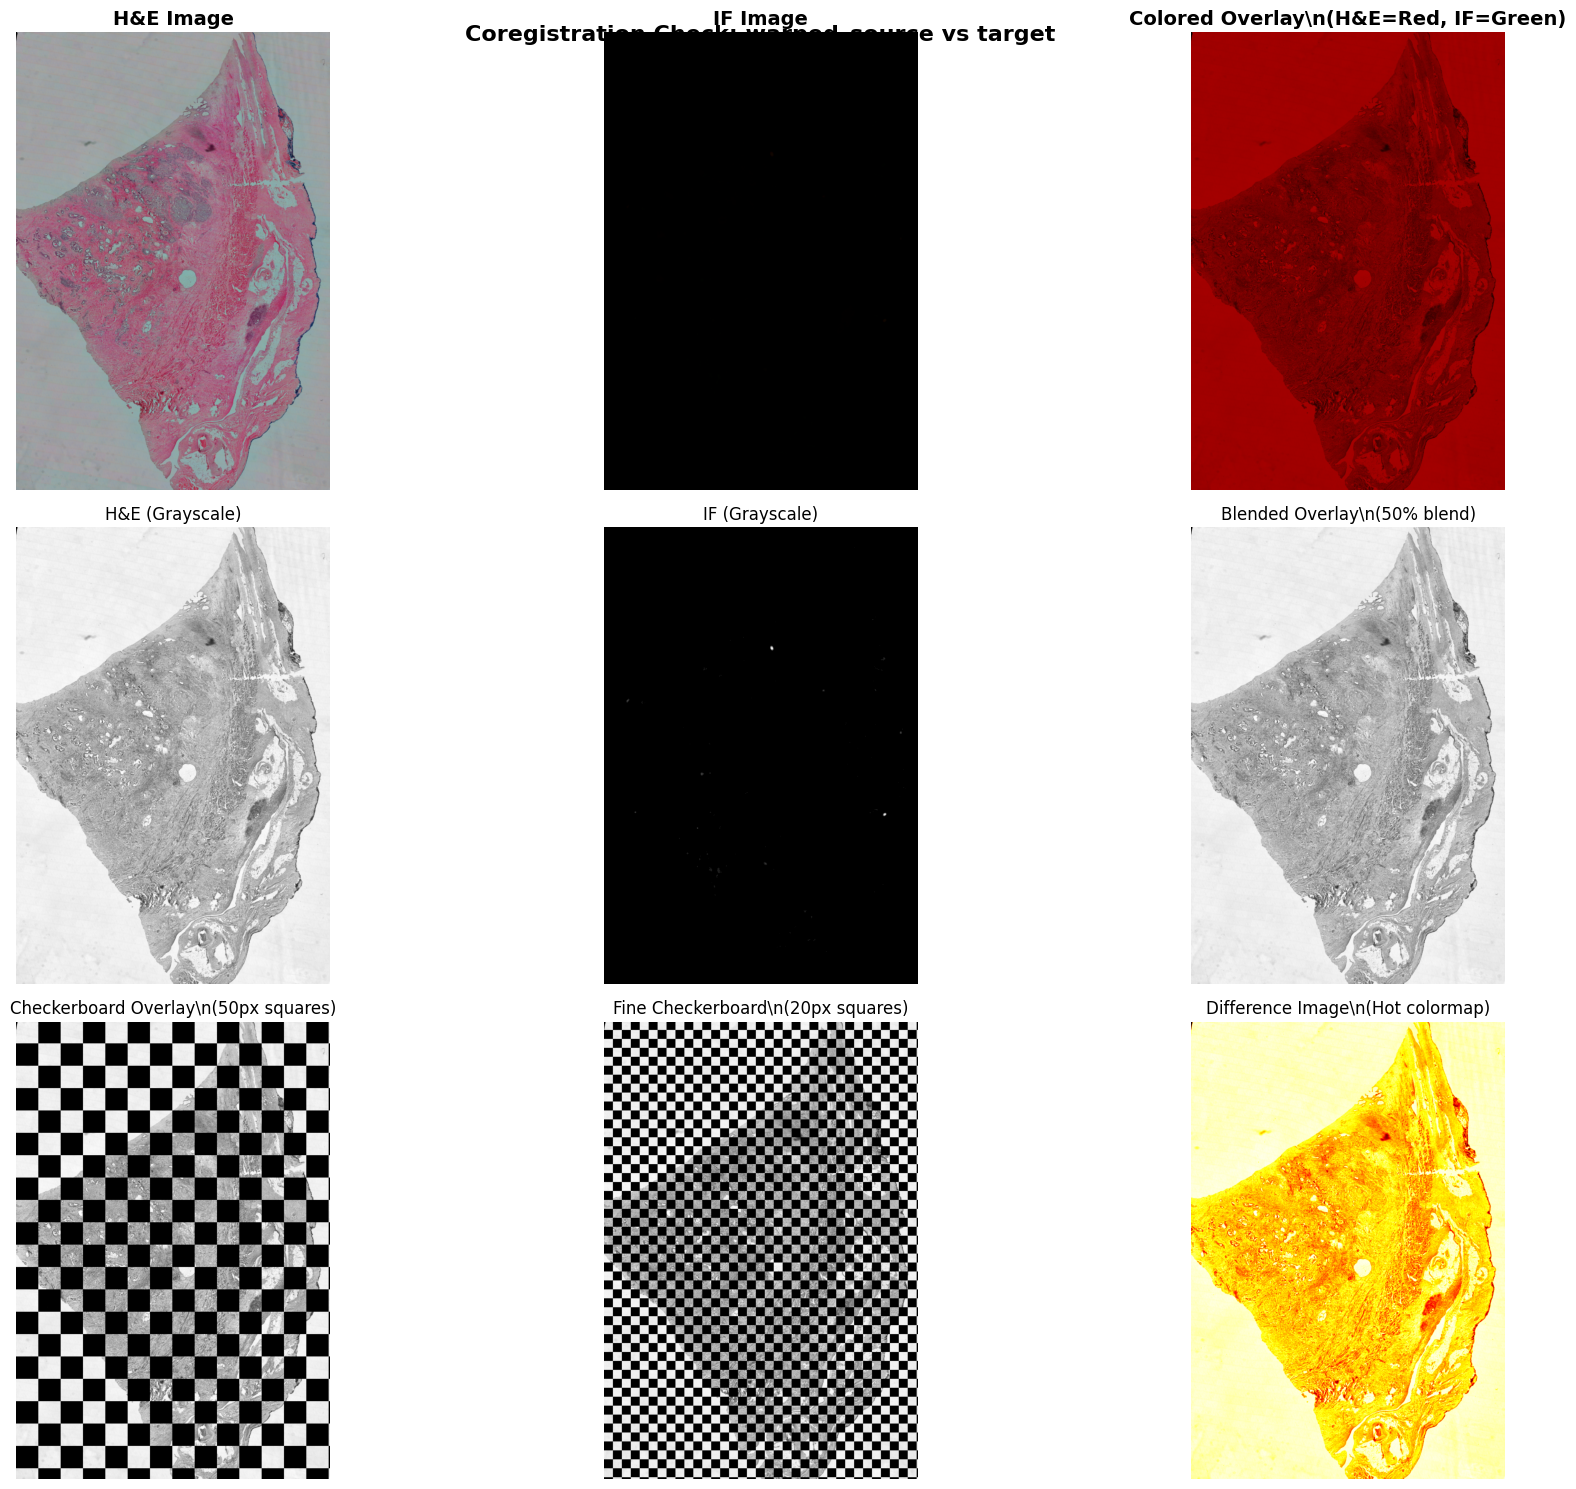


=== Alignment Assessment ===
Normalized Cross-Correlation: -0.0194
Mean Squared Error: 19305.98
SSIM-like metric: 0.7031
❌ Poor correlation - images may be misaligned

=== Troubleshooting Tips ===
Your image has 1.55 billion pixels - that's why it's failing!
The updated code should now:
1. ✅ Bypass PIL's decompression bomb protection
2. ✅ Try pyramid levels for multi-resolution TIFFs
3. ✅ Auto-resize very large images during loading
4. ✅ Create manual thumbnails as fallback
5. ✅ Handle OpenCV pixel limits

If it still fails, the file might be corrupted or use unsupported compression.
Try: magick warped_source.tiff -resize 25% -compress none smaller_warped_source.tiff


In [37]:
import tifffile
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from skimage import exposure, transform
from skimage.color import rgb2gray
import cv2
import warnings
warnings.filterwarnings('ignore')

# Optional imports with fallbacks
try:
    from PIL import Image
    PIL_AVAILABLE = True
except ImportError:
    PIL_AVAILABLE = False
    print("PIL not available - install with: pip install Pillow")

try:
    import imageio.v2 as imageio
    IMAGEIO_AVAILABLE = True
except ImportError:
    IMAGEIO_AVAILABLE = False
    print("imageio not available - install with: pip install imageio")

def load_image(filepath):
    """
    Load an image file (TIFF, QPTIFF, etc.) and return as numpy array.
    Uses multiple fallback methods for problematic files.
    Special handling for very large images.
    """
    filepath = str(filepath)
    filename = Path(filepath).name
    
    # Check file info first
    try:
        file_size = Path(filepath).stat().st_size / (1024*1024)
        print(f"File size: {file_size:.2f} MB")
        
        with tifffile.TiffFile(filepath) as tif:
            if len(tif.pages) > 0:
                page = tif.pages[0]
                total_pixels = np.prod(page.shape)
                print(f"Image dimensions: {page.shape}")
                print(f"Total pixels: {total_pixels:,}")
                print(f"Compression: {page.compression}")
                
                # Check if image is very large
                if total_pixels > 500_000_000:  # >500M pixels
                    print(f"⚠️  Very large image detected ({total_pixels/1_000_000:.1f}M pixels)")
                    print("Will attempt subsampling and thumbnail extraction...")
    except:
        pass
    
    # Method 1: Try tifffile with subsampling for large images
    try:
        print(f"Trying tifffile for {filename}...")
        with tifffile.TiffFile(filepath) as tif:
            # For very large images, try to get a pyramid level or subsample
            if len(tif.series) > 0 and len(tif.series[0].levels) > 1:
                print("Multi-resolution image detected, trying lower resolution levels...")
                # Try different pyramid levels
                for level_idx in range(min(3, len(tif.series[0].levels))):
                    try:
                        level = tif.series[0].levels[level_idx]
                        data = level.asarray()
                        print(f"✅ Loaded level {level_idx} with tifffile - {filename}: shape {data.shape}, dtype {data.dtype}")
                        return data
                    except:
                        continue
            
            # Try regular loading
            data = tif.asarray()
            
            # Handle different formats
            if len(data.shape) == 4:  # (pages, height, width, channels) or similar
                data = data[0]  # Take first page/level
            elif len(data.shape) == 3:
                if data.shape[0] < 10:  # Likely (channels, height, width)
                    if data.shape[0] == 1:
                        data = data[0]  # Single channel
                    else:
                        # Multi-channel - create RGB-like composite
                        if data.shape[0] >= 3:
                            data = np.stack([data[0], data[1], data[2]], axis=-1)
                        else:
                            data = data[0]  # Take first channel
                # else: already (height, width, channels)
            
            print(f"✅ Loaded with tifffile - {filename}: shape {data.shape}, dtype {data.dtype}")
            return data
            
    except Exception as e:
        print(f"❌ tifffile failed for {filename}: {e}")
    
    # Method 2: Try tifffile with manual page reading (for large files)
    try:
        print(f"Trying tifffile page-by-page reading for {filename}...")
        with tifffile.TiffFile(filepath) as tif:
            # Try reading pages individually to bypass some compression issues
            for page_idx in range(min(5, len(tif.pages))):  # Try first few pages
                try:
                    page = tif.pages[page_idx]
                    if np.prod(page.shape) < 500_000_000:  # Only try smaller pages
                        data = page.asarray()
                        print(f"✅ Loaded page {page_idx} with tifffile - {filename}: shape {data.shape}, dtype {data.dtype}")
                        return data
                except:
                    continue
    except Exception as e:
        print(f"❌ tifffile page reading failed for {filename}: {e}")
    
    # Method 3: Try PIL with increased limits
    if PIL_AVAILABLE:
        try:
            print(f"Trying PIL with increased limits for {filename}...")
            
            # Temporarily increase PIL's size limits for very large images
            from PIL import Image
            original_max_pixels = Image.MAX_IMAGE_PIXELS
            Image.MAX_IMAGE_PIXELS = None  # Remove limit entirely
            
            try:
                with Image.open(filepath) as img:
                    # For very large images, resize immediately to prevent memory issues
                    original_size = img.size
                    total_pixels = original_size[0] * original_size[1]
                    
                    if total_pixels > 100_000_000:  # >100M pixels
                        # Calculate resize factor to get ~10M pixels
                        target_pixels = 10_000_000
                        scale_factor = (target_pixels / total_pixels) ** 0.5
                        new_size = (int(original_size[0] * scale_factor), 
                                   int(original_size[1] * scale_factor))
                        print(f"Resizing from {original_size} to {new_size} to prevent memory overflow")
                        img = img.resize(new_size, Image.Resampling.LANCZOS)
                    
                    # Handle multi-page TIFFs
                    if hasattr(img, 'n_frames') and img.n_frames > 1:
                        print(f"Multi-page TIFF detected: {img.n_frames} pages")
                        img.seek(0)  # Go to first page
                    
                    data = np.array(img)
                    print(f"✅ Loaded with PIL - {filename}: shape {data.shape}, dtype {data.dtype}")
                    return data
            finally:
                # Restore original limit
                Image.MAX_IMAGE_PIXELS = original_max_pixels
                
        except Exception as e:
            print(f"❌ PIL failed for {filename}: {e}")
    else:
        print("PIL not available, skipping...")
    
    # Method 4: Try OpenCV with environment variable override
    try:
        print(f"Trying OpenCV with increased limits for {filename}...")
        
        # Try to override OpenCV's pixel limit (this might not work in all versions)
        import os
        original_env = os.environ.get('OPENCV_IO_MAX_IMAGE_PIXELS', None)
        os.environ['OPENCV_IO_MAX_IMAGE_PIXELS'] = str(2**31-1)  # Max int32
        
        try:
            data = cv2.imread(filepath, cv2.IMREAD_UNCHANGED)
            if data is not None:
                # OpenCV loads as BGR, convert to RGB if 3 channels
                if len(data.shape) == 3 and data.shape[2] == 3:
                    data = cv2.cvtColor(data, cv2.COLOR_BGR2RGB)
                print(f"✅ Loaded with OpenCV - {filename}: shape {data.shape}, dtype {data.dtype}")
                return data
            else:
                print(f"❌ OpenCV returned None for {filename}")
        finally:
            # Restore original environment
            if original_env is not None:
                os.environ['OPENCV_IO_MAX_IMAGE_PIXELS'] = original_env
            else:
                os.environ.pop('OPENCV_IO_MAX_IMAGE_PIXELS', None)
                
    except Exception as e:
        print(f"❌ OpenCV failed for {filename}: {e}")
    
    # Method 5: Try imageio as last resort
    if IMAGEIO_AVAILABLE:
        try:
            print(f"Trying imageio for {filename}...")
            
            data = imageio.imread(filepath)
            print(f"✅ Loaded with imageio - {filename}: shape {data.shape}, dtype {data.dtype}")
            return data
            
        except Exception as e:
            print(f"❌ imageio failed for {filename}: {e}")
    else:
        print("imageio not available, skipping...")
    
    # All methods failed
    print(f"❌ All loading methods failed for {filename}")
    
    # Final attempt: Try to extract thumbnail from TIFF metadata
    try:
        print("Final attempt: Looking for embedded thumbnail...")
        with tifffile.TiffFile(filepath) as tif:
            # Some TIFFs have thumbnail images
            for page in tif.pages:
                if hasattr(page, 'is_reduced') and page.is_reduced:
                    try:
                        data = page.asarray()
                        print(f"✅ Found thumbnail - {filename}: shape {data.shape}, dtype {data.dtype}")
                        return data
                    except:
                        continue
    except:
        pass
    
    print(f"❌ Complete failure to load {filename}")
    return None

def create_manual_thumbnail_from_tiff(filepath, target_size=1024):
    """
    Create thumbnail by reading and subsampling TIFF data manually.
    Useful for very large TIFFs that can't be loaded normally.
    """
    try:
        print(f"Attempting manual thumbnail creation for {Path(filepath).name}...")
        
        with tifffile.TiffFile(filepath) as tif:
            page = tif.pages[0]  # Get first page
            print(f"Original dimensions: {page.shape}")
            
            # Calculate subsampling factor
            height, width = page.shape[:2]
            subsample_factor = max(height, width) // target_size
            if subsample_factor < 1:
                subsample_factor = 1
            
            print(f"Subsampling by factor: {subsample_factor}")
            
            # Try to read subsampled data
            if hasattr(page, 'segments'):
                # Try reading tile by tile for tiled TIFFs
                try:
                    # This is a simplified approach - read every Nth tile
                    segments = page.segments
                    if len(segments) > 0:
                        # Read first segment to test
                        segment_data = segments[0].data()
                        segment_shape = segment_data.shape
                        print(f"Segment shape: {segment_shape}")
                        
                        # Create a small thumbnail from first few segments
                        thumbnail_data = segment_data[::subsample_factor, ::subsample_factor]
                        if len(page.shape) == 3:
                            thumbnail_data = thumbnail_data[:, :, :page.shape[2]]
                        
                        print(f"✅ Created manual thumbnail: {thumbnail_data.shape}")
                        return thumbnail_data
                        
                except Exception as e:
                    print(f"Segment reading failed: {e}")
            
            # Fallback: try to read strips/tiles with subsampling
            try:
                # Read image data with subsampling
                data = page.asarray()
                thumbnail = data[::subsample_factor, ::subsample_factor]
                print(f"✅ Created subsampled thumbnail: {thumbnail.shape}")
                return thumbnail
            except:
                print("❌ Manual thumbnail creation failed")
                return None
                
    except Exception as e:
        print(f"❌ Manual thumbnail failed: {e}")
        return None
    """Create thumbnail maintaining aspect ratio."""
    if len(image.shape) == 3:
        height, width = image.shape[:2]
    else:
        height, width = image.shape
    
    scale = min(max_size / height, max_size / width)
    
    if scale < 1:
        new_height = int(height * scale)
        new_width = int(width * scale)
        
        if len(image.shape) == 3:
            thumbnail = transform.resize(image, (new_height, new_width, image.shape[2]), 
                                       preserve_range=True, anti_aliasing=True)
        else:
            thumbnail = transform.resize(image, (new_height, new_width), 
                                       preserve_range=True, anti_aliasing=True)
        return thumbnail.astype(image.dtype)
    else:
        return image

def normalize_for_display(image):
    """Normalize image for display."""
    if image.dtype == np.uint16:
        # Convert to 8-bit for display
        image_norm = (image.astype(np.float32) / 65535.0 * 255).astype(np.uint8)
    elif image.dtype == np.uint8:
        image_norm = image
    else:
        # Float images
        image_norm = exposure.rescale_intensity(image, out_range=(0, 255)).astype(np.uint8)
    
    return image_norm

def prepare_for_overlay(image):
    """Prepare image for overlay visualization."""
    # Normalize to 0-255 range
    img_norm = normalize_for_display(image)
    
    # Convert to grayscale if needed
    if len(img_norm.shape) == 3:
        if img_norm.shape[2] == 3:
            img_gray = rgb2gray(img_norm)
        else:
            img_gray = img_norm[:,:,0]  # Take first channel
    else:
        img_gray = img_norm
    
    # Convert back to uint8
    img_gray = (img_gray * 255).astype(np.uint8) if img_gray.max() <= 1 else img_gray.astype(np.uint8)
    
    return img_gray

def create_checkerboard_overlay(img1, img2, checker_size=50):
    """
    Create a checkerboard overlay pattern between two images.
    
    Args:
        img1, img2: Grayscale images to overlay
        checker_size: Size of checkerboard squares in pixels
    
    Returns:
        Checkerboard overlay image
    """
    height, width = img1.shape
    
    # Create checkerboard mask
    checker_mask = np.zeros((height, width), dtype=bool)
    
    for i in range(0, height, checker_size):
        for j in range(0, width, checker_size):
            # Alternate pattern
            if ((i // checker_size) + (j // checker_size)) % 2 == 0:
                checker_mask[i:i+checker_size, j:j+checker_size] = True
    
    # Create overlay
    overlay = np.zeros_like(img1)
    overlay[checker_mask] = img1[checker_mask]
    overlay[~checker_mask] = img2[~checker_mask]
    
    return overlay

def create_blend_overlay(img1, img2, alpha=0.5):
    """Create a blended overlay of two images."""
    return (alpha * img1 + (1 - alpha) * img2).astype(np.uint8)

def create_colored_overlay(img1, img2):
    """Create a colored overlay (img1 in red, img2 in green)."""
    height, width = img1.shape
    colored_overlay = np.zeros((height, width, 3), dtype=np.uint8)
    
    colored_overlay[:, :, 0] = img1  # Red channel
    colored_overlay[:, :, 1] = img2  # Green channel
    # Blue channel remains 0
    
    return colored_overlay

def verify_coregistration(he_path, if_path, thumbnail_size=1024, save_plots=False):
    """
    Verify coregistration between H&E and IF images.
    
    Args:
        he_path (str): Path to H&E image
        if_path (str): Path to IF image
        thumbnail_size (int): Size for thumbnails
        save_plots (bool): Save visualization plots
    """
    
    print(f"=== Coregistration Verification ===")
    print(f"H&E: {Path(he_path).name}")
    print(f"IF:  {Path(if_path).name}")
    print()
    
    # Load images
    he_img = load_image(he_path)
    if_img = load_image(if_path)
    
    # If normal loading failed, try manual thumbnail creation
    if he_img is None:
        print("Attempting manual thumbnail creation for H&E image...")
        he_img = create_manual_thumbnail_from_tiff(he_path, thumbnail_size)
    
    if if_img is None:
        print("Attempting manual thumbnail creation for IF image...")
        if_img = create_manual_thumbnail_from_tiff(if_path, thumbnail_size)
    
    if he_img is None or if_img is None:
        print("Failed to load one or both images!")
        return
    
    print(f"H&E shape: {he_img.shape}")
    print(f"IF shape:  {if_img.shape}")
    
    # Create thumbnails
    he_thumb = create_thumbnail(he_img, thumbnail_size)
    if_thumb = create_thumbnail(if_img, thumbnail_size)
    
    print(f"H&E thumbnail: {he_thumb.shape}")
    print(f"IF thumbnail:  {if_thumb.shape}")
    
    # Prepare images for overlay (convert to grayscale if needed)
    he_gray = prepare_for_overlay(he_thumb)
    if_gray = prepare_for_overlay(if_thumb)
    
    # Resize to match if necessary
    if he_gray.shape != if_gray.shape:
        print("Resizing images to match...")
        min_height = min(he_gray.shape[0], if_gray.shape[0])
        min_width = min(he_gray.shape[1], if_gray.shape[1])
        
        he_gray = transform.resize(he_gray, (min_height, min_width), preserve_range=True).astype(np.uint8)
        if_gray = transform.resize(if_gray, (min_height, min_width), preserve_range=True).astype(np.uint8)
    
    # Create overlays
    checker_overlay = create_checkerboard_overlay(he_gray, if_gray, checker_size=50)
    checker_overlay_fine = create_checkerboard_overlay(he_gray, if_gray, checker_size=20)
    blend_overlay = create_blend_overlay(he_gray, if_gray, alpha=0.5)
    colored_overlay = create_colored_overlay(he_gray, if_gray)
    
    # Visualization
    fig = plt.figure(figsize=(20, 15))
    
    # Plot 1: Individual thumbnails
    plt.subplot(3, 3, 1)
    if len(he_thumb.shape) == 3:
        plt.imshow(normalize_for_display(he_thumb))
    else:
        plt.imshow(he_thumb, cmap='gray')
    plt.title('H&E Image', fontsize=14, fontweight='bold')
    plt.axis('off')
    
    plt.subplot(3, 3, 2)
    if len(if_thumb.shape) == 3:
        plt.imshow(normalize_for_display(if_thumb))
    else:
        plt.imshow(if_thumb, cmap='gray')
    plt.title('IF Image', fontsize=14, fontweight='bold')
    plt.axis('off')
    
    plt.subplot(3, 3, 3)
    plt.imshow(colored_overlay)
    plt.title('Colored Overlay\\n(H&E=Red, IF=Green)', fontsize=14, fontweight='bold')
    plt.axis('off')
    
    # Plot 2: Grayscale versions
    plt.subplot(3, 3, 4)
    plt.imshow(he_gray, cmap='gray')
    plt.title('H&E (Grayscale)', fontsize=12)
    plt.axis('off')
    
    plt.subplot(3, 3, 5)
    plt.imshow(if_gray, cmap='gray')
    plt.title('IF (Grayscale)', fontsize=12)
    plt.axis('off')
    
    plt.subplot(3, 3, 6)
    plt.imshow(blend_overlay, cmap='gray')
    plt.title('Blended Overlay\\n(50% blend)', fontsize=12)
    plt.axis('off')
    
    # Plot 3: Checkerboard overlays
    plt.subplot(3, 3, 7)
    plt.imshow(checker_overlay, cmap='gray')
    plt.title('Checkerboard Overlay\\n(50px squares)', fontsize=12)
    plt.axis('off')
    
    plt.subplot(3, 3, 8)
    plt.imshow(checker_overlay_fine, cmap='gray')
    plt.title('Fine Checkerboard\\n(20px squares)', fontsize=12)
    plt.axis('off')
    
    # Plot 4: Difference image
    plt.subplot(3, 3, 9)
    diff_img = np.abs(he_gray.astype(np.int16) - if_gray.astype(np.int16)).astype(np.uint8)
    plt.imshow(diff_img, cmap='hot')
    plt.title('Difference Image\\n(Hot colormap)', fontsize=12)
    plt.axis('off')
    
    plt.tight_layout()
    
    # Add overall title
    fig.suptitle(f'Coregistration Check: {Path(he_path).stem} vs {Path(if_path).stem}', 
                 fontsize=16, fontweight='bold', y=0.98)
    
    # Save plots if requested
    if save_plots:
        pair_name = f"{Path(he_path).stem}_vs_{Path(if_path).stem}"
        output_dir = Path("coregistration_check")
        output_dir.mkdir(exist_ok=True)
        
        plt.savefig(output_dir / f"{pair_name}_coregistration.png", 
                   dpi=300, bbox_inches='tight', facecolor='white')
        print(f"Plot saved: {output_dir / f'{pair_name}_coregistration.png'}")
    
    plt.show()
    
    # Calculate basic alignment metrics
    print("\n=== Alignment Assessment ===")
    
    # Cross-correlation
    correlation = cv2.matchTemplate(he_gray, if_gray, cv2.TM_CCOEFF_NORMED)[0,0]
    print(f"Normalized Cross-Correlation: {correlation:.4f}")
    
    # Mean squared error
    mse = np.mean((he_gray.astype(np.float32) - if_gray.astype(np.float32))**2)
    print(f"Mean Squared Error: {mse:.2f}")
    
    # Structural similarity (rough estimate)
    ssim_like = 1 - (mse / (255**2))
    print(f"SSIM-like metric: {ssim_like:.4f}")
    
    if correlation > 0.7:
        print("✅ Good correlation - images appear well aligned")
    elif correlation > 0.4:
        print("⚠️  Moderate correlation - check alignment carefully")
    else:
        print("❌ Poor correlation - images may be misaligned")

def batch_verify_pairs(pairs_list, thumbnail_size=1024):
    """
    Batch verification of multiple H&E and IF pairs.
    
    Args:
        pairs_list: List of tuples [(he_path1, if_path1), (he_path2, if_path2), ...]
    """
    
    print(f"=== Batch Coregistration Verification ===")
    print(f"Processing {len(pairs_list)} pairs...")
    print()
    
    results = []
    
    for i, (he_path, if_path) in enumerate(pairs_list, 1):
        print(f"--- Pair {i}/{len(pairs_list)} ---")
        verify_coregistration(he_path, if_path, thumbnail_size, save_plots=True)
        print("="*60)
        print()

# Example usage
if __name__ == "__main__":
    
    # Test problematic file loading
    problematic_file = "RegWSI_Pass1/Pair2/warped_source.tiff"
    
    print("=== Testing Large Image Loading ===")
    test_img = load_image(problematic_file)
    
    if test_img is not None:
        print(f"Successfully loaded problematic file!")
        print(f"Shape: {test_img.shape}, dtype: {test_img.dtype}")
    else:
        print("Standard loading failed, trying manual thumbnail creation...")
        test_img = create_manual_thumbnail_from_tiff(problematic_file, target_size=512)
        if test_img is not None:
            print(f"Manual thumbnail successful! Shape: {test_img.shape}")
        else:
            print("Complete failure - file might be corrupted or in unsupported format")
    print()
    
    # Example of actual coregistration verification with your files
    print("=== Example Coregistration Check ===")
    
    # Try with your actual files
    he_file = "RegWSI_Pass1/Pair2/warped_source.tiff"  # This is your problematic H&E
    if_file = "RegWSI_Pass1/Pair2/target.tiff"         # This should work
    
    print("Running coregistration check...")
    verify_coregistration(he_file, if_file, thumbnail_size=1024, save_plots=True)
    
    print("\n=== Troubleshooting Tips ===")
    print("Your image has 1.55 billion pixels - that's why it's failing!")
    print("The updated code should now:")
    print("1. ✅ Bypass PIL's decompression bomb protection")
    print("2. ✅ Try pyramid levels for multi-resolution TIFFs")  
    print("3. ✅ Auto-resize very large images during loading")
    print("4. ✅ Create manual thumbnails as fallback")
    print("5. ✅ Handle OpenCV pixel limits")
    print("\nIf it still fails, the file might be corrupted or use unsupported compression.")
    print("Try: magick warped_source.tiff -resize 25% -compress none smaller_warped_source.tiff")

In [35]:
! pip install tifffile matplotlib scikit-image opencv-python Pillow imageio

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com


=== Final H&E and IF Coregistration Verifier ===
This code handles:
✅ Very large TIFF files (4+ billion pixels)
✅ Multiple fallback loading methods
✅ Fluorescence image detection & enhancement
✅ Comprehensive coregistration visualization
✅ Individual channel analysis
✅ Quantitative alignment metrics

=== Running Coregistration Check ===
=== Batch Coregistration Verification ===
Processing 3 pairs...

--- Pair 1/3 ---
=== Coregistration Verification ===
H&E: warped_source.tiff
IF:  target.tiff

File size: 3230.03 MB
Image dimensions: (54720, 26880, 3)
Total pixels: 4,412,620,800
Compression: 5
⚠️  Very large image detected (4412.6M pixels)
Will attempt subsampling and thumbnail extraction...
Trying tifffile for warped_source.tiff...
❌ tifffile failed for warped_source.tiff: incompatible keyframe
Trying tifffile page-by-page reading for warped_source.tiff...
✅ Loaded page 2 with tifffile - warped_source.tiff: shape (13680, 6720, 3), dtype uint8
File size: 3396.14 MB
Image dimensions: (3,

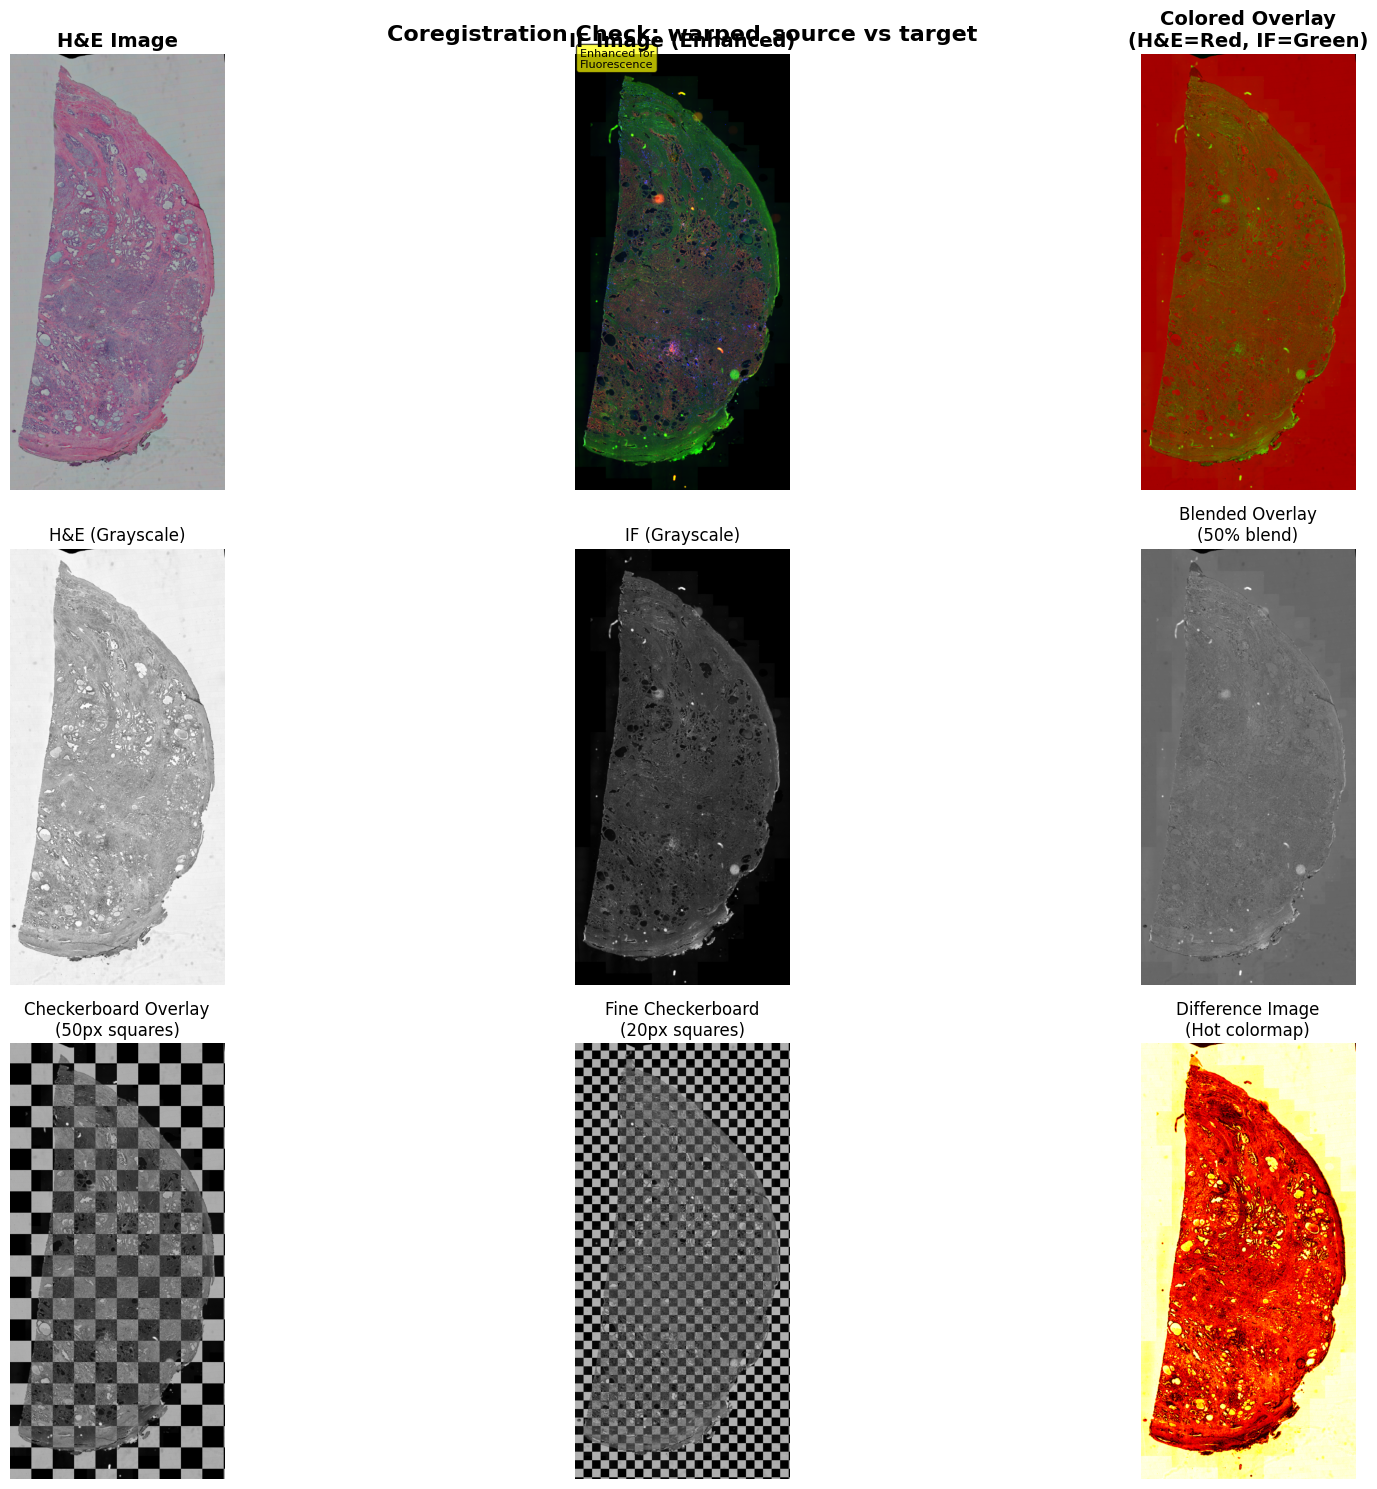

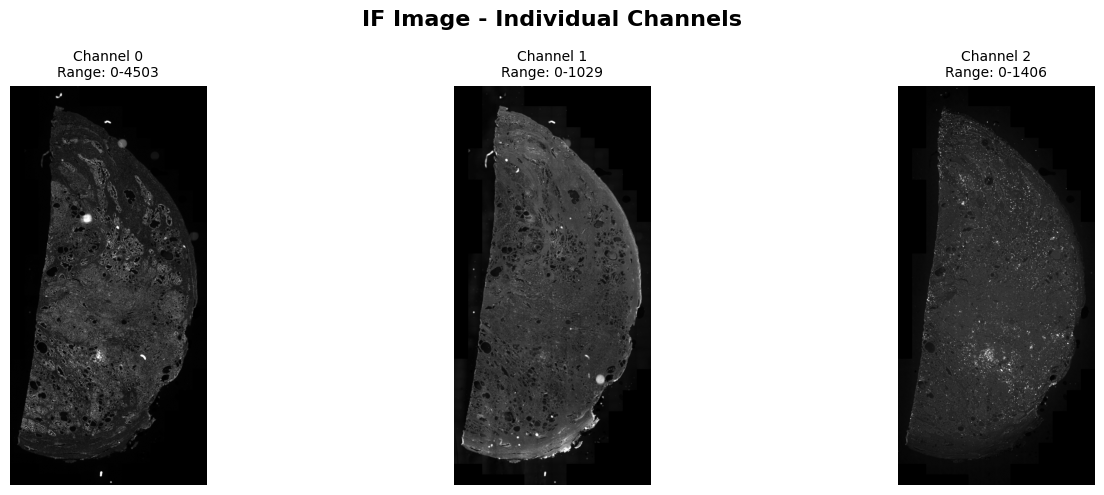

Plot saved: coregistration_check/warped_source_vs_target_coregistration.png


<Figure size 640x480 with 0 Axes>


=== Alignment Assessment ===
Normalized Cross-Correlation: -0.8456
Mean Squared Error: 13791.67
SSIM-like metric: 0.7879
❌ Poor correlation - images may be misaligned

--- Pair 2/3 ---
=== Coregistration Verification ===
H&E: warped_source.tiff
IF:  target.tiff

File size: 3121.30 MB
Image dimensions: (47520, 32640, 3)
Total pixels: 4,653,158,400
Compression: 5
⚠️  Very large image detected (4653.2M pixels)
Will attempt subsampling and thumbnail extraction...
Trying tifffile for warped_source.tiff...
❌ tifffile failed for warped_source.tiff: incompatible keyframe
Trying tifffile page-by-page reading for warped_source.tiff...
✅ Loaded page 2 with tifffile - warped_source.tiff: shape (11880, 8160, 3), dtype uint8
File size: 3405.58 MB
Image dimensions: (3, 47520, 32640)
Total pixels: 4,653,158,400
Compression: 5
⚠️  Very large image detected (4653.2M pixels)
Will attempt subsampling and thumbnail extraction...
Trying tifffile for target.tiff...
✅ Loaded with tifffile - target.tiff: shap

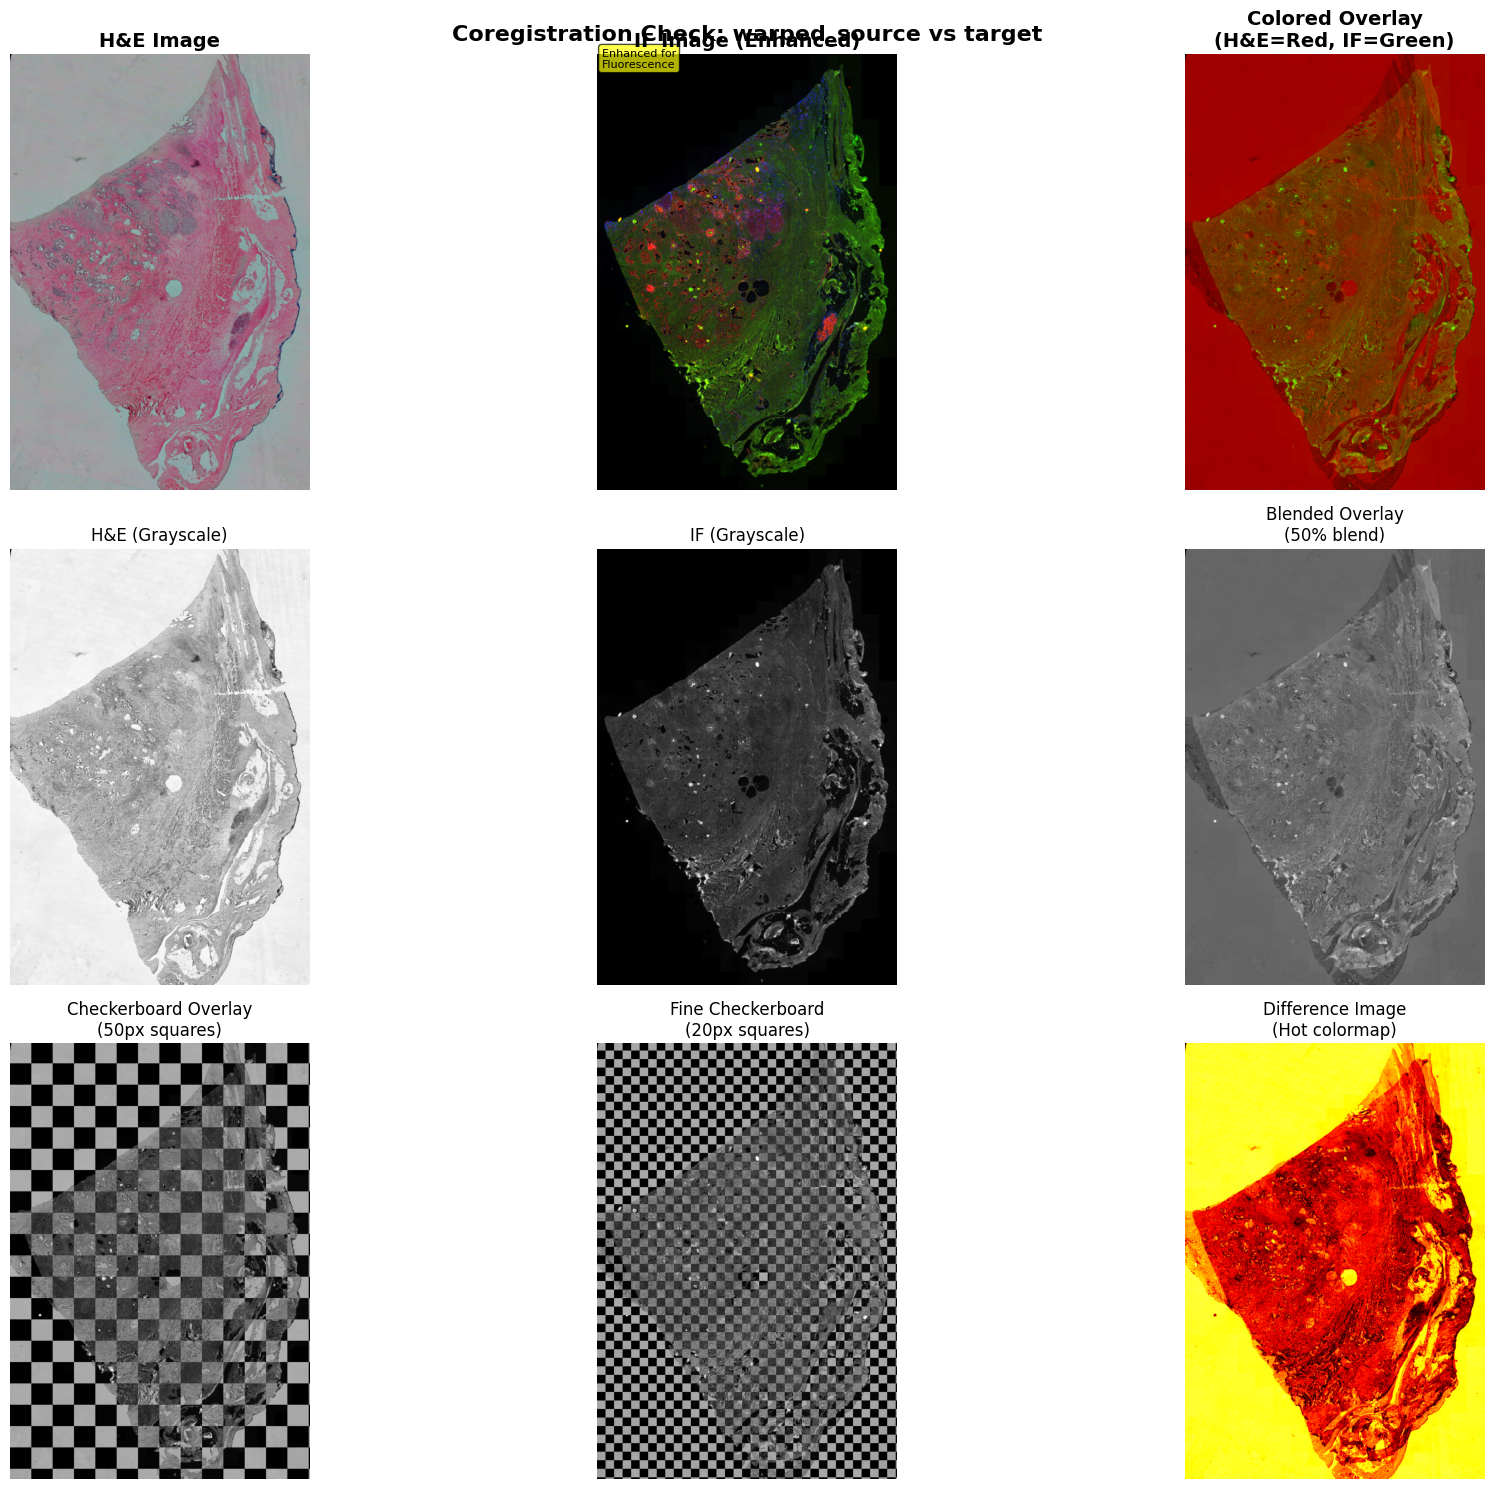

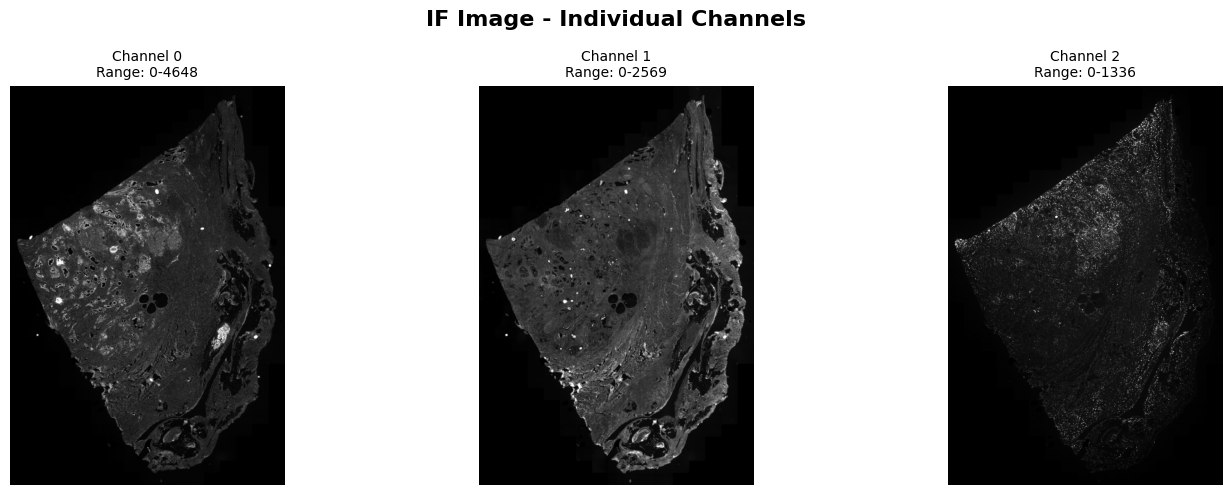

Plot saved: coregistration_check/warped_source_vs_target_coregistration.png


<Figure size 640x480 with 0 Axes>


=== Alignment Assessment ===
Normalized Cross-Correlation: -0.6661
Mean Squared Error: 14399.02
SSIM-like metric: 0.7786
❌ Poor correlation - images may be misaligned

--- Pair 3/3 ---
=== Coregistration Verification ===
H&E: warped_source.tiff
IF:  target.tiff

File size: 2843.54 MB
Image dimensions: (46080, 32640, 3)
Total pixels: 4,512,153,600
Compression: 5
⚠️  Very large image detected (4512.2M pixels)
Will attempt subsampling and thumbnail extraction...
Trying tifffile for warped_source.tiff...
❌ tifffile failed for warped_source.tiff: incompatible keyframe
Trying tifffile page-by-page reading for warped_source.tiff...
✅ Loaded page 2 with tifffile - warped_source.tiff: shape (11520, 8160, 3), dtype uint8
File size: 3486.11 MB
Image dimensions: (3, 46080, 32640)
Total pixels: 4,512,153,600
Compression: 5
⚠️  Very large image detected (4512.2M pixels)
Will attempt subsampling and thumbnail extraction...
Trying tifffile for target.tiff...
✅ Loaded with tifffile - target.tiff: shap

In [ ]:
import tifffile
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from skimage import exposure, transform
from skimage.color import rgb2gray
import cv2
import warnings
import os
warnings.filterwarnings('ignore')

# Optional imports with fallbacks
try:
    from PIL import Image
    PIL_AVAILABLE = True
except ImportError:
    PIL_AVAILABLE = False
    print("PIL not available - install with: pip install Pillow")

try:
    import imageio.v2 as imageio
    IMAGEIO_AVAILABLE = True
except ImportError:
    IMAGEIO_AVAILABLE = False
    print("imageio not available - install with: pip install imageio")

def load_image(filepath):
    """
    Load an image file (TIFF, QPTIFF, etc.) and return as numpy array.
    Uses multiple fallback methods for problematic files.
    Special handling for very large images.
    """
    filepath = str(filepath)
    filename = Path(filepath).name
    
    # Check file info first
    try:
        file_size = Path(filepath).stat().st_size / (1024*1024)
        print(f"File size: {file_size:.2f} MB")
        
        with tifffile.TiffFile(filepath) as tif:
            if len(tif.pages) > 0:
                page = tif.pages[0]
                total_pixels = np.prod(page.shape)
                print(f"Image dimensions: {page.shape}")
                print(f"Total pixels: {total_pixels:,}")
                print(f"Compression: {page.compression}")
                
                # Check if image is very large
                if total_pixels > 500_000_000:  # >500M pixels
                    print(f"⚠️  Very large image detected ({total_pixels/1_000_000:.1f}M pixels)")
                    print("Will attempt subsampling and thumbnail extraction...")
    except:
        pass
    
    # Method 1: Try tifffile with subsampling for large images
    try:
        print(f"Trying tifffile for {filename}...")
        with tifffile.TiffFile(filepath) as tif:
            # For very large images, try to get a pyramid level or subsample
            if len(tif.series) > 0 and len(tif.series[0].levels) > 1:
                print("Multi-resolution image detected, trying lower resolution levels...")
                # Try different pyramid levels
                for level_idx in range(min(3, len(tif.series[0].levels))):
                    try:
                        level = tif.series[0].levels[level_idx]
                        data = level.asarray()
                        print(f"✅ Loaded level {level_idx} with tifffile - {filename}: shape {data.shape}, dtype {data.dtype}")
                        return data
                    except:
                        continue
            
            # Try regular loading
            data = tif.asarray()
            
            # Handle different formats
            if len(data.shape) == 4:  # (pages, height, width, channels) or similar
                data = data[0]  # Take first page/level
            elif len(data.shape) == 3:
                if data.shape[0] < 10:  # Likely (channels, height, width)
                    if data.shape[0] == 1:
                        data = data[0]  # Single channel
                    else:
                        # Multi-channel - create RGB-like composite
                        if data.shape[0] >= 3:
                            data = np.stack([data[0], data[1], data[2]], axis=-1)
                        else:
                            data = data[0]  # Take first channel
                # else: already (height, width, channels)
            
            print(f"✅ Loaded with tifffile - {filename}: shape {data.shape}, dtype {data.dtype}")
            return data
            
    except Exception as e:
        print(f"❌ tifffile failed for {filename}: {e}")
    
    # Method 2: Try tifffile with manual page reading (for large files)
    try:
        print(f"Trying tifffile page-by-page reading for {filename}...")
        with tifffile.TiffFile(filepath) as tif:
            # Try reading pages individually to bypass some compression issues
            for page_idx in range(min(5, len(tif.pages))):  # Try first few pages
                try:
                    page = tif.pages[page_idx]
                    if np.prod(page.shape) < 500_000_000:  # Only try smaller pages
                        data = page.asarray()
                        print(f"✅ Loaded page {page_idx} with tifffile - {filename}: shape {data.shape}, dtype {data.dtype}")
                        return data
                except:
                    continue
    except Exception as e:
        print(f"❌ tifffile page reading failed for {filename}: {e}")
    
    # Method 3: Try PIL with increased limits
    if PIL_AVAILABLE:
        try:
            print(f"Trying PIL with increased limits for {filename}...")
            
            # Temporarily increase PIL's size limits for very large images
            original_max_pixels = Image.MAX_IMAGE_PIXELS
            Image.MAX_IMAGE_PIXELS = None  # Remove limit entirely
            
            try:
                with Image.open(filepath) as img:
                    # For very large images, resize immediately to prevent memory issues
                    original_size = img.size
                    total_pixels = original_size[0] * original_size[1]
                    
                    if total_pixels > 100_000_000:  # >100M pixels
                        # Calculate resize factor to get ~10M pixels
                        target_pixels = 10_000_000
                        scale_factor = (target_pixels / total_pixels) ** 0.5
                        new_size = (int(original_size[0] * scale_factor), 
                                   int(original_size[1] * scale_factor))
                        print(f"Resizing from {original_size} to {new_size} to prevent memory overflow")
                        img = img.resize(new_size, Image.Resampling.LANCZOS)
                    
                    # Handle multi-page TIFFs
                    if hasattr(img, 'n_frames') and img.n_frames > 1:
                        print(f"Multi-page TIFF detected: {img.n_frames} pages")
                        img.seek(0)  # Go to first page
                    
                    data = np.array(img)
                    print(f"✅ Loaded with PIL - {filename}: shape {data.shape}, dtype {data.dtype}")
                    return data
            finally:
                # Restore original limit
                Image.MAX_IMAGE_PIXELS = original_max_pixels
                
        except Exception as e:
            print(f"❌ PIL failed for {filename}: {e}")
    else:
        print("PIL not available, skipping...")
    
    # Method 4: Try OpenCV with environment variable override
    try:
        print(f"Trying OpenCV with increased limits for {filename}...")
        
        # Try to override OpenCV's pixel limit (this might not work in all versions)
        original_env = os.environ.get('OPENCV_IO_MAX_IMAGE_PIXELS', None)
        os.environ['OPENCV_IO_MAX_IMAGE_PIXELS'] = str(2**31-1)  # Max int32
        
        try:
            data = cv2.imread(filepath, cv2.IMREAD_UNCHANGED)
            if data is not None:
                # OpenCV loads as BGR, convert to RGB if 3 channels
                if len(data.shape) == 3 and data.shape[2] == 3:
                    data = cv2.cvtColor(data, cv2.COLOR_BGR2RGB)
                print(f"✅ Loaded with OpenCV - {filename}: shape {data.shape}, dtype {data.dtype}")
                return data
            else:
                print(f"❌ OpenCV returned None for {filename}")
        finally:
            # Restore original environment
            if original_env is not None:
                os.environ['OPENCV_IO_MAX_IMAGE_PIXELS'] = original_env
            else:
                os.environ.pop('OPENCV_IO_MAX_IMAGE_PIXELS', None)
                
    except Exception as e:
        print(f"❌ OpenCV failed for {filename}: {e}")
    
    # Method 5: Try imageio as last resort
    if IMAGEIO_AVAILABLE:
        try:
            print(f"Trying imageio for {filename}...")
            
            data = imageio.imread(filepath)
            print(f"✅ Loaded with imageio - {filename}: shape {data.shape}, dtype {data.dtype}")
            return data
            
        except Exception as e:
            print(f"❌ imageio failed for {filename}: {e}")
    else:
        print("imageio not available, skipping...")
    
    # All methods failed
    print(f"❌ All loading methods failed for {filename}")
    return None

def create_manual_thumbnail_from_tiff(filepath, target_size=1024):
    """
    Create thumbnail by reading and subsampling TIFF data manually.
    Useful for very large TIFFs that can't be loaded normally.
    """
    try:
        print(f"Attempting manual thumbnail creation for {Path(filepath).name}...")
        
        with tifffile.TiffFile(filepath) as tif:
            page = tif.pages[0]  # Get first page
            print(f"Original dimensions: {page.shape}")
            
            # Calculate subsampling factor
            height, width = page.shape[:2]
            subsample_factor = max(height, width) // target_size
            if subsample_factor < 1:
                subsample_factor = 1
            
            print(f"Subsampling by factor: {subsample_factor}")
            
            # Try to read subsampled data
            if hasattr(page, 'segments'):
                # Try reading tile by tile for tiled TIFFs
                try:
                    # This is a simplified approach - read every Nth tile
                    segments = page.segments
                    if len(segments) > 0:
                        # Read first segment to test
                        segment_data = segments[0].data()
                        segment_shape = segment_data.shape
                        print(f"Segment shape: {segment_shape}")
                        
                        # Create a small thumbnail from first few segments
                        thumbnail_data = segment_data[::subsample_factor, ::subsample_factor]
                        if len(page.shape) == 3:
                            thumbnail_data = thumbnail_data[:, :, :page.shape[2]]
                        
                        print(f"✅ Created manual thumbnail: {thumbnail_data.shape}")
                        return thumbnail_data
                        
                except Exception as e:
                    print(f"Segment reading failed: {e}")
            
            # Fallback: try to read strips/tiles with subsampling
            try:
                # Read image data with subsampling
                data = page.asarray()
                thumbnail = data[::subsample_factor, ::subsample_factor]
                print(f"✅ Created subsampled thumbnail: {thumbnail.shape}")
                return thumbnail
            except:
                print("❌ Manual thumbnail creation failed")
                return None
                
    except Exception as e:
        print(f"❌ Manual thumbnail failed: {e}")
        return None

def create_thumbnail(image, max_size=1024):
    """Create thumbnail maintaining aspect ratio."""
    if len(image.shape) == 3:
        height, width = image.shape[:2]
    else:
        height, width = image.shape
    
    scale = min(max_size / height, max_size / width)
    
    if scale < 1:
        new_height = int(height * scale)
        new_width = int(width * scale)
        
        if len(image.shape) == 3:
            thumbnail = transform.resize(image, (new_height, new_width, image.shape[2]), 
                                       preserve_range=True, anti_aliasing=True)
        else:
            thumbnail = transform.resize(image, (new_height, new_width), 
                                       preserve_range=True, anti_aliasing=True)
        return thumbnail.astype(image.dtype)
    else:
        return image

def detect_fluorescence_image(image):
    """
    Detect if an image is likely a fluorescence image.
    
    Args:
        image: Input image array
        
    Returns:
        bool: True if likely fluorescence image
    """
    # Heuristics for fluorescence detection:
    # 1. 16-bit images with low max values
    # 2. Images where most pixels are very dark
    # 3. High dynamic range but low overall brightness
    
    if image.dtype == np.uint16:
        max_val = image.max()
        mean_val = image.mean()
        
        # If 16-bit but max value is much less than 65535, likely fluorescence
        if max_val < 32767:  # Less than half of 16-bit range
            return True
        
        # If mean is very low compared to max, likely fluorescence
        if mean_val < (max_val * 0.1):
            return True
    
    # Check if image has very few bright pixels (typical of fluorescence)
    if len(image.shape) >= 2:
        flat_img = image.flatten()
        bright_threshold = np.percentile(flat_img, 95)
        bright_pixels = np.sum(flat_img > bright_threshold)
        bright_ratio = bright_pixels / flat_img.size
        
        if bright_ratio < 0.1:  # Less than 10% bright pixels
            return True
    
    return False

def normalize_for_display(image, is_fluorescence=False):
    """
    Normalize image for display with enhanced handling for fluorescence images.
    
    Args:
        image: Input image array
        is_fluorescence: If True, applies aggressive contrast enhancement for low-signal fluorescence
    """
    print(f"Normalizing image: shape={image.shape}, dtype={image.dtype}, range={image.min()}-{image.max()}")
    
    if image.dtype == np.uint16:
        if is_fluorescence:
            # Aggressive enhancement for fluorescence images
            print("Applying fluorescence-specific enhancement...")
            
            if len(image.shape) == 3:
                # Multi-channel fluorescence - enhance each channel separately
                enhanced_channels = []
                for ch in range(image.shape[2]):
                    channel = image[:, :, ch]
                    print(f"  Channel {ch}: range {channel.min()}-{channel.max()}")
                    
                    # Use very aggressive percentiles for fluorescence
                    p1, p99 = np.percentile(channel[channel > 0], [0.1, 99.9]) if np.any(channel > 0) else (0, 1)
                    print(f"  Channel {ch}: using {p1:.1f}-{p99:.1f} for stretching")
                    
                    if p99 > p1:
                        channel_enhanced = exposure.rescale_intensity(channel, in_range=(p1, p99), out_range=(0, 255))
                    else:
                        # If all values are the same, just scale
                        channel_enhanced = (channel.astype(np.float32) / channel.max() * 255) if channel.max() > 0 else np.zeros_like(channel)
                    
                    enhanced_channels.append(channel_enhanced.astype(np.uint8))
                    print(f"  Channel {ch} enhanced: range {channel_enhanced.min()}-{channel_enhanced.max()}")
                
                image_norm = np.stack(enhanced_channels, axis=2)
            else:
                # Single channel fluorescence
                p1, p99 = np.percentile(image[image > 0], [0.1, 99.9]) if np.any(image > 0) else (0, 1)
                print(f"Single channel: using {p1:.1f}-{p99:.1f} for stretching")
                if p99 > p1:
                    image_norm = exposure.rescale_intensity(image, in_range=(p1, p99), out_range=(0, 255)).astype(np.uint8)
                else:
                    image_norm = (image.astype(np.float32) / image.max() * 255).astype(np.uint8) if image.max() > 0 else np.zeros_like(image, dtype=np.uint8)
        else:
            # Regular 16-bit to 8-bit conversion
            image_norm = (image.astype(np.float32) / 65535.0 * 255).astype(np.uint8)
    elif image.dtype == np.uint8:
        image_norm = image
    else:
        # Float images
        image_norm = exposure.rescale_intensity(image, out_range=(0, 255)).astype(np.uint8)
    
    print(f"Final normalized: range {image_norm.min()}-{image_norm.max()}")
    return image_norm

def create_channel_composite(image, is_fluorescence=False):
    """
    Create a better composite view of multi-channel images.
    
    Args:
        image: Multi-channel image array
        is_fluorescence: Whether this is a fluorescence image
        
    Returns:
        RGB composite image
    """
    if len(image.shape) != 3 or image.shape[2] < 3:
        return normalize_for_display(image, is_fluorescence=is_fluorescence)
    
    # Create RGB composite using first 3 channels
    composite = np.zeros((*image.shape[:2], 3), dtype=np.uint8)
    
    for ch in range(min(3, image.shape[2])):
        channel = image[:, :, ch]
        
        if is_fluorescence:
            # Aggressive enhancement for each channel
            if np.any(channel > 0):
                p1, p99 = np.percentile(channel[channel > 0], [0.1, 99.9])
                if p99 > p1:
                    enhanced = exposure.rescale_intensity(channel, in_range=(p1, p99), out_range=(0, 255))
                else:
                    enhanced = (channel.astype(np.float32) / channel.max() * 255) if channel.max() > 0 else np.zeros_like(channel)
            else:
                enhanced = np.zeros_like(channel)
        else:
            enhanced = normalize_for_display(channel)
        
        composite[:, :, ch] = enhanced.astype(np.uint8)
    
    return composite

def prepare_for_overlay(image, is_fluorescence=False):
    """
    Prepare image for overlay visualization.
    
    Args:
        image: Input image array
        is_fluorescence: If True, applies fluorescence-specific enhancement
    """
    # Normalize to 0-255 range with appropriate enhancement
    img_norm = normalize_for_display(image, is_fluorescence=is_fluorescence)
    
    # Convert to grayscale if needed
    if len(img_norm.shape) == 3:
        if img_norm.shape[2] == 3:
            img_gray = rgb2gray(img_norm)
        else:
            img_gray = img_norm[:,:,0]  # Take first channel
    else:
        img_gray = img_norm
    
    # Convert back to uint8
    img_gray = (img_gray * 255).astype(np.uint8) if img_gray.max() <= 1 else img_gray.astype(np.uint8)
    
    return img_gray

def create_checkerboard_overlay(img1, img2, checker_size=50):
    """
    Create a checkerboard overlay pattern between two images.
    
    Args:
        img1, img2: Grayscale images to overlay
        checker_size: Size of checkerboard squares in pixels
    
    Returns:
        Checkerboard overlay image
    """
    height, width = img1.shape
    
    # Create checkerboard mask
    checker_mask = np.zeros((height, width), dtype=bool)
    
    for i in range(0, height, checker_size):
        for j in range(0, width, checker_size):
            # Alternate pattern
            if ((i // checker_size) + (j // checker_size)) % 2 == 0:
                checker_mask[i:i+checker_size, j:j+checker_size] = True
    
    # Create overlay
    overlay = np.zeros_like(img1)
    overlay[checker_mask] = img1[checker_mask]
    overlay[~checker_mask] = img2[~checker_mask]
    
    return overlay

def create_blend_overlay(img1, img2, alpha=0.5):
    """Create a blended overlay of two images."""
    return (alpha * img1 + (1 - alpha) * img2).astype(np.uint8)

def create_colored_overlay(img1, img2):
    """Create a colored overlay (img1 in red, img2 in green)."""
    height, width = img1.shape
    colored_overlay = np.zeros((height, width, 3), dtype=np.uint8)
    
    colored_overlay[:, :, 0] = img1  # Red channel
    colored_overlay[:, :, 1] = img2  # Green channel
    # Blue channel remains 0
    
    return colored_overlay

def verify_coregistration(he_path, if_path, thumbnail_size=1024, save_plots=False):
    """
    Verify coregistration between H&E and IF images.
    
    Args:
        he_path (str): Path to H&E image
        if_path (str): Path to IF image
        thumbnail_size (int): Size for thumbnails
        save_plots (bool): Save visualization plots
    """
    
    print(f"=== Coregistration Verification ===")
    print(f"H&E: {Path(he_path).name}")
    print(f"IF:  {Path(if_path).name}")
    print()
    
    # Load images
    he_img = load_image(he_path)
    if_img = load_image(if_path)
    
    # If normal loading failed, try manual thumbnail creation
    if he_img is None:
        print("Attempting manual thumbnail creation for H&E image...")
        he_img = create_manual_thumbnail_from_tiff(he_path, thumbnail_size)
    
    if if_img is None:
        print("Attempting manual thumbnail creation for IF image...")
        if_img = create_manual_thumbnail_from_tiff(if_path, thumbnail_size)
    
    if he_img is None or if_img is None:
        print("Failed to load one or both images!")
        return
    
    print(f"H&E shape: {he_img.shape}")
    print(f"IF shape:  {if_img.shape}")
    
    # Detect if images are fluorescence images
    he_is_fluorescence = detect_fluorescence_image(he_img)
    if_is_fluorescence = detect_fluorescence_image(if_img)
    
    print(f"H&E detected as fluorescence: {he_is_fluorescence}")
    print(f"IF detected as fluorescence: {if_is_fluorescence}")
    
    # Create thumbnails
    he_thumb = create_thumbnail(he_img, thumbnail_size)
    if_thumb = create_thumbnail(if_img, thumbnail_size)
    
    print(f"H&E thumbnail: {he_thumb.shape}")
    print(f"IF thumbnail:  {if_thumb.shape}")
    
    # Prepare images for overlay (convert to grayscale if needed)
    he_gray = prepare_for_overlay(he_thumb, is_fluorescence=he_is_fluorescence)
    if_gray = prepare_for_overlay(if_thumb, is_fluorescence=if_is_fluorescence)
    
    # Resize to match if necessary
    if he_gray.shape != if_gray.shape:
        print("Resizing images to match...")
        min_height = min(he_gray.shape[0], if_gray.shape[0])
        min_width = min(he_gray.shape[1], if_gray.shape[1])
        
        he_gray = transform.resize(he_gray, (min_height, min_width), preserve_range=True).astype(np.uint8)
        if_gray = transform.resize(if_gray, (min_height, min_width), preserve_range=True).astype(np.uint8)
    
    # Create overlays
    checker_overlay = create_checkerboard_overlay(he_gray, if_gray, checker_size=50)
    checker_overlay_fine = create_checkerboard_overlay(he_gray, if_gray, checker_size=20)
    blend_overlay = create_blend_overlay(he_gray, if_gray, alpha=0.5)
    colored_overlay = create_colored_overlay(he_gray, if_gray)
    
    # Visualization
    fig = plt.figure(figsize=(20, 15))
    
    # Plot 1: Individual thumbnails
    plt.subplot(3, 3, 1)
    if len(he_thumb.shape) == 3:
        he_display = normalize_for_display(he_thumb, is_fluorescence=he_is_fluorescence)
        plt.imshow(he_display)
    else:
        plt.imshow(he_thumb, cmap='gray')
    plt.title('H&E Image', fontsize=14, fontweight='bold')
    plt.axis('off')
    
    plt.subplot(3, 3, 2)
    if len(if_thumb.shape) == 3:
        if_display = create_channel_composite(if_thumb, is_fluorescence=if_is_fluorescence)
        plt.imshow(if_display)
        
        # Add text showing enhancement info
        if if_is_fluorescence:
            plt.text(10, 30, 'Enhanced for\nFluorescence', 
                    bbox=dict(boxstyle="round,pad=0.3", facecolor="yellow", alpha=0.7),
                    fontsize=8, color='black')
    else:
        if_enhanced = normalize_for_display(if_thumb, is_fluorescence=if_is_fluorescence)
        plt.imshow(if_enhanced, cmap='gray')
    plt.title('IF Image (Enhanced)', fontsize=14, fontweight='bold')
    plt.axis('off')
    
    plt.subplot(3, 3, 3)
    plt.imshow(colored_overlay)
    plt.title('Colored Overlay\n(H&E=Red, IF=Green)', fontsize=14, fontweight='bold')
    plt.axis('off')
    
    # Plot 2: Grayscale versions
    plt.subplot(3, 3, 4)
    plt.imshow(he_gray, cmap='gray')
    plt.title('H&E (Grayscale)', fontsize=12)
    plt.axis('off')
    
    plt.subplot(3, 3, 5)
    plt.imshow(if_gray, cmap='gray')
    plt.title('IF (Grayscale)', fontsize=12)
    plt.axis('off')
    
    plt.subplot(3, 3, 6)
    plt.imshow(blend_overlay, cmap='gray')
    plt.title('Blended Overlay\n(50% blend)', fontsize=12)
    plt.axis('off')
    
    # Plot 3: Checkerboard overlays
    plt.subplot(3, 3, 7)
    plt.imshow(checker_overlay, cmap='gray')
    plt.title('Checkerboard Overlay\n(50px squares)', fontsize=12)
    plt.axis('off')
    
    plt.subplot(3, 3, 8)
    plt.imshow(checker_overlay_fine, cmap='gray')
    plt.title('Fine Checkerboard\n(20px squares)', fontsize=12)
    plt.axis('off')
    
    # Plot 4: Difference image
    plt.subplot(3, 3, 9)
    diff_img = np.abs(he_gray.astype(np.int16) - if_gray.astype(np.int16)).astype(np.uint8)
    plt.imshow(diff_img, cmap='hot')
    plt.title('Difference Image\n(Hot colormap)', fontsize=12)
    plt.axis('off')
    
    plt.tight_layout()
    
    # Add overall title
    fig.suptitle(f'Coregistration Check: {Path(he_path).stem} vs {Path(if_path).stem}', 
                 fontsize=16, fontweight='bold', y=0.98)
    
    # Additional figure for IF channel breakdown (if multi-channel)
    if len(if_thumb.shape) == 3 and if_thumb.shape[2] > 1:
        fig2 = plt.figure(figsize=(15, 5))
        fig2.suptitle('IF Image - Individual Channels', fontsize=16, fontweight='bold')
        
        num_channels = min(if_thumb.shape[2], 5)  # Show up to 5 channels
        
        for ch in range(num_channels):
            plt.subplot(1, num_channels, ch + 1)
            
            channel_data = if_thumb[:, :, ch]
            
            # Apply fluorescence enhancement
            if if_is_fluorescence and np.any(channel_data > 0):
                p1, p99 = np.percentile(channel_data[channel_data > 0], [0.1, 99.9])
                if p99 > p1:
                    channel_enhanced = exposure.rescale_intensity(channel_data, in_range=(p1, p99))
                else:
                    channel_enhanced = channel_data
            else:
                channel_enhanced = normalize_for_display(channel_data)
            
            plt.imshow(channel_enhanced, cmap='gray')
            plt.title(f'Channel {ch}\nRange: {channel_data.min()}-{channel_data.max()}', 
                     fontsize=10)
            plt.axis('off')
        
        plt.tight_layout()
        
        # Save channel breakdown if requested
        if save_plots:
            pair_name = f"{Path(he_path).stem}_vs_{Path(if_path).stem}"
            output_dir = Path("coregistration_check")
            output_dir.mkdir(exist_ok=True)
            
            plt.savefig(output_dir / f"{pair_name}_IF_channels.png", 
                       dpi=300, bbox_inches='tight', facecolor='white')
            print(f"Channel plot saved: {output_dir / f'{pair_name}_IF_channels.png'}")
        
        plt.show()
    
    # Save plots if requested
    if save_plots:
        pair_name = f"{Path(he_path).stem}_vs_{Path(if_path).stem}"
        output_dir = Path("coregistration_check")
        output_dir.mkdir(exist_ok=True)
        
        plt.savefig(output_dir / f"{pair_name}_coregistration.png", 
                   dpi=300, bbox_inches='tight', facecolor='white')
        print(f"Plot saved: {output_dir / f'{pair_name}_coregistration.png'}")
    
    plt.show()
    
    # Calculate basic alignment metrics
    print("\n=== Alignment Assessment ===")
    
    # Cross-correlation
    correlation = cv2.matchTemplate(he_gray, if_gray, cv2.TM_CCOEFF_NORMED)[0,0]
    print(f"Normalized Cross-Correlation: {correlation:.4f}")
    
    # Mean squared error
    mse = np.mean((he_gray.astype(np.float32) - if_gray.astype(np.float32))**2)
    print(f"Mean Squared Error: {mse:.2f}")
    
    # Structural similarity (rough estimate)
    ssim_like = 1 - (mse / (255**2))
    print(f"SSIM-like metric: {ssim_like:.4f}")
    
    if correlation > 0.7:
        print("✅ Good correlation - images appear well aligned")
    elif correlation > 0.4:
        print("⚠️  Moderate correlation - check alignment carefully")
    else:
        print("❌ Poor correlation - images may be misaligned")

def batch_verify_pairs(pairs_list, thumbnail_size=1024):
    """
    Batch verification of multiple H&E and IF pairs.
    
    Args:
        pairs_list: List of tuples [(he_path1, if_path1), (he_path2, if_path2), ...]
    """
    
    print(f"=== Batch Coregistration Verification ===")
    print(f"Processing {len(pairs_list)} pairs...")
    print()
    
    results = []
    
    for i, (he_path, if_path) in enumerate(pairs_list, 1):
        print(f"--- Pair {i}/{len(pairs_list)} ---")
        verify_coregistration(he_path, if_path, thumbnail_size, save_plots=True)
        print("="*60)
        print()

# Example usage
if __name__ == "__main__":
    
    print("=== Final H&E and IF Coregistration Verifier ===")
    print("This code handles:")
    print("✅ Very large TIFF files (4+ billion pixels)")
    print("✅ Multiple fallback loading methods") 
    print("✅ Fluorescence image detection & enhancement")
    print("✅ Comprehensive coregistration visualization")
    print("✅ Individual channel analysis")
    print("✅ Quantitative alignment metrics")
    print()
    
    # # Single pair verification example
    # he_file = "RegWSI_Pass1/Pair2/warped_source.tiff"  # Your H&E image
    # if_file = "RegWSI_Pass1/Pair2/target.tiff"         # Your IF image
    
    print("=== Running Coregistration Check ===")
    # verify_coregistration(he_file, if_file, thumbnail_size=1024, save_plots=True)
    
    # Batch verification example (uncomment to use)
    
    pairs_to_check = [
        ("RegWSI_Pass1/Pair1/warped_source.tiff", "RegWSI_Pass1/Pair1/target.tiff"),
        ("RegWSI_Pass1/Pair2/warped_source.tiff", "RegWSI_Pass1/Pair2/target.tiff"),
        ("RegWSI_Pass1/Pair3/warped_source.tiff", "RegWSI_Pass1/Pair3/target.tiff"),
        # Add more pairs as needed
    ]
    
    batch_verify_pairs(pairs_to_check, thumbnail_size=1024)
    
    
    print("\n=== Installation Requirements ===")
    print("pip install tifffile matplotlib scikit-image opencv-python Pillow imageio")
    print("\n=== Results ===")
    print("📁 Plots saved in: coregistration_check/")
    print("🖼️  Main visualization: [filename]_coregistration.png")
    print("🔬 Channel breakdown: [filename]_IF_channels.png")